## SINDY+RRLyrae

##### We apply pysindy to variable star light curves, reconstructing the dynamics in the form of a first order system (equivalent to a single second order equation). The feature library (the base of functions against which pysindy regresses the derivatives to find governing equations) is polynomial of order 2 with interaction at this stage.

In [31]:
import numpy as np
import time
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import os
import random
from numpy.linalg import norm
from statsmodels.graphics.tsaplots import plot_pacf
import time
from scipy.stats import ks_2samp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
%matplotlib inline

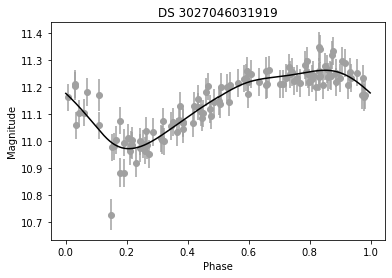

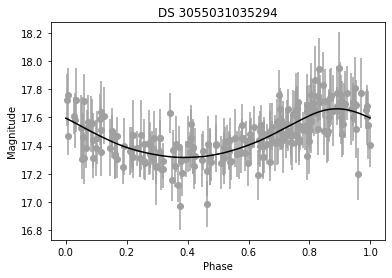

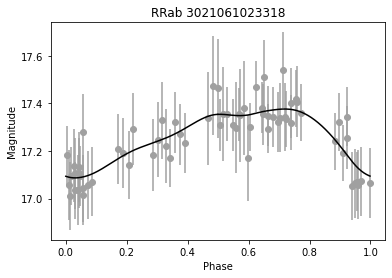

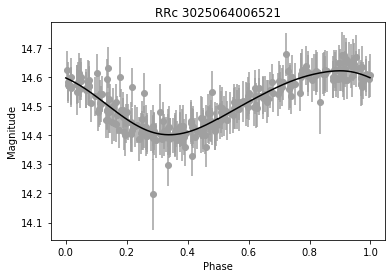

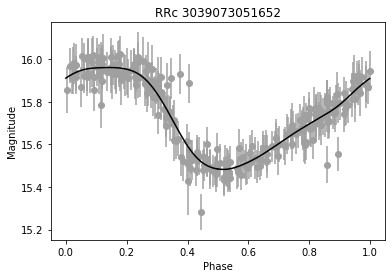

In [32]:
def plotMeThisStarForBono(star):
    justOneStar = pd.read_csv("../MoeAbbas/" + star)
    andItsSpline = pd.read_csv(star)
    plt.errorbar(justOneStar["Phase"], justOneStar["Mag"], yerr=justOneStar["Mag_err"], fmt="o", color = "#A0A0A0", zorder=-32)
    t = andItsSpline["t"]
    x = np.median(justOneStar["Mag"]) + andItsSpline["x"]
    plt.plot(t[t < 1], x[t < 1], color = "#000000")
    plt.plot(t[(t < 1.5) & (t > 1)]-1, x[(t < 1.5) & (t > 1)], color = "#000000")
    plt.ylabel("Magnitude")
    plt.xlabel("Phase")
    title = star.replace("/", " ").replace('.csv', '').replace('DeltaScuti9', 'DS').replace('b1', 'b').replace('c2','c')
    plt.title(title)
    plt.show()
    
starsToPlotForBono = ["DeltaScuti9/3027046031919.csv", "DeltaScuti9/3055031035294.csv", "RRab1/3021061023318.csv", "RRab1/3025046038291.csv", "RRc2/3025064006521.csv", "RRc2/3039073051652.csv"]

for star in starsToPlotForBono:
    plotMeThisStarForBono(star)

In [33]:
DataColor = "#A0A0A0"
SimulationColor = "#FFFFFF00" #"#EB5160"
SimulationColor2 = "#FFFFFF00" #"#249000"
SimulationColor3 = "#FFFFFF00" #"#124480"

def fromMiddle(cmap):
    if(cmap=="Reds"):
        newcmp = ListedColormap([[min(2*x,1), 0.0, 0.0] for x in np.linspace(0,1,512)])
    if(cmap=="Greens"):
        newcmp = ListedColormap([[0.0, min(2*x,1), 0.0] for x in np.linspace(0,1,512)])
    if(cmap=="Blues"):
        newcmp = ListedColormap([[0.0, 0.0, min(2*x,1)] for x in np.linspace(0,1,512)])
    return newcmp
    
def lineCollectionPlot(t, x, y, cmap, ax):
    points = np.array([x,y]).transpose().reshape(-1,1,2)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    lc = LineCollection(segs, cmap=fromMiddle(cmap))
    lc.set_array(t) # color the segments by our parameter
    ax.add_collection(lc) # add the collection to the plot

def justPlotTheCurve(t, X, star):
    rrderiv = pd.read_csv(star) #I calculated the derivative with a spline here
    Xt = rrderiv[['t', 'x', 'xdot']]
    Xt = Xt.sort_values(by='t')
    t = np.array(Xt[['t']])
    X = np.array(Xt[['x', 'xdot']])
    ID = int(os.path.split(star)[1][:-4])
    star_type = os.path.split(star)[0]
    plt.plot(t-t[0], X[:,0], linewidth=2, color=DataColor)
    #plt.text(t-t[0],X[:,0]+0.35, star_type[2:-1] + " #" + str(ID))

def manyCurves(t, X, s1, s2, s3, star):    
    ID = int(os.path.split(star)[1][:-4])
    star_type = os.path.split(star)[0]
    fig, axs = plt.subplots(nrows=2, ncols=2)
    axs[1,0].plot(X[:,0], t-t[0], linewidth=1, linestyle = "dotted", color=DataColor)
    #axs[1,0].plot(s1[:,0], t-t[0], linewidth=1.5, color=SimulationColor)
    #lineCollectionPlot(t-t[0], s1[:,0], t-t[0], "Reds", axs[1,0])
    axs[1,0].plot(s2[:,0], t-t[0], linewidth=1.5, color=SimulationColor2)
    lineCollectionPlot(t-t[0], s2[:,0], t-t[0], "Greens", axs[1,0])
    axs[1,0].plot(s3[:,0], t-t[0], linewidth=1.5, color=SimulationColor3)
    lineCollectionPlot(t-t[0], s3[:,0], t-t[0], "Blues", axs[1,0])
    axs[1,0].set_ylim([-0.05,4.1])
    axs[1,0].set_ylabel("time")
    axs[1,0].set_xlabel("Magnitude (median subtracted)")
    axs[0,1].plot(t-t[0], X[:,1], linewidth=1, linestyle = "dotted", color=DataColor)
    #axs[0,1].plot(t-t[0], s1[:,1], linewidth=1.5, color=SimulationColor)
    #lineCollectionPlot(t-t[0], t-t[0], s1[:,1], "Reds", axs[0,1])
    axs[0,1].plot(t-t[0], s2[:,1], linewidth=1.5, color=SimulationColor2)
    lineCollectionPlot(t-t[0], t-t[0], s2[:,1], "Greens", axs[0,1])
    axs[0,1].plot(t-t[0], s3[:,1], linewidth=1.5, color=SimulationColor3)
    lineCollectionPlot(t-t[0], t-t[0], s3[:,1], "Blues", axs[0,1])
    axs[0,1].set_xlabel("time")
    axs[0,1].set_xlim([-0.1,4.05])
    axs[0,1].axes.yaxis.set_visible(False)
    axs[0,0].plot(X[:,0], X[:,1], linewidth=1, linestyle = "dotted", color=DataColor)
    #axs[0,0].plot(s1[:,0], s1[:,1], linewidth=1.5, color=SimulationColor)
    #lineCollectionPlot(t-t[0], s1[:,0], s1[:,1], "Reds", axs[0,0])    
    axs[0,0].plot(s2[:,0], s2[:,1], linewidth=1.5, color=SimulationColor2)
    lineCollectionPlot(t-t[0], s2[:,0], s2[:,1], "Greens", axs[0,0])    
    axs[0,0].plot(s3[:,0], s3[:,1], linewidth=1.5, color=SimulationColor3)
    lineCollectionPlot(t-t[0], s3[:,0], s3[:,1], "Blues", axs[0,0])
    axs[0,0].axes.xaxis.set_visible(False)
    axs[0,0].set_ylabel("Magnitude derivative")
    axs[1,1].axis("off")
    axs[1,1].text(0.17,0.35, star_type[2:-1] + " #" + str(ID))
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()

def showTheCurves(t, X, s, star):
    ID = int(os.path.split(star)[1][:-4])
    star_type = os.path.split(star)[0]
    fromt = round(9*len(t)/10)
    tot = round(len(t)/10)
    fig, axs = plt.subplots(nrows=2, ncols=2)
    axs[1,0].plot(X[fromt:,0], t[fromt:]-t[fromt], linewidth=4, linestyle = "dotted", color=DataColor)
    axs[1,0].plot(s[fromt:,0], t[fromt:]-t[fromt], linewidth=1.5, color=SimulationColor)
    axs[1,0].set_ylim([-0.05,1.1])
    axs[1,0].set_ylabel("time")
    axs[1,0].set_xlabel("Magnitude (median subtracted)")
    axs[0,1].plot(t[fromt:]-t[fromt], X[fromt:,1], linewidth=4, linestyle = "dotted", color=DataColor)
    axs[0,1].plot(t[fromt:]-t[fromt], s[fromt:,1], linewidth=1.5, color=SimulationColor)
    axs[0,1].set_xlabel("time")
    axs[0,1].set_xlim([-0.1,1.05])
    axs[0,1].axes.yaxis.set_visible(False)
    
    axs[0,0].plot(X[fromt:,0], X[fromt:,1], linewidth=4, linestyle = "dotted", color=DataColor)
    axs[0,0].plot(s[fromt:,0], s[fromt:,1], linewidth=1.5, color=SimulationColor)
    axs[0,0].axes.xaxis.set_visible(False)
    axs[0,0].set_ylabel("Magnitude derivative")
    
    axs[1,1].axis("off")
    axs[1,1].text(0.17,0.35, star_type[2:-1] + " #" + str(ID))
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()
    
def readOneStar(star):
    rrderiv = pd.read_csv(star) #I calculated the derivative with a spline here
    Xt = rrderiv[['t', 'x', 'xdot']]
    Xt = Xt.sort_values(by='t')
    t = np.array(Xt[['t']])
    X = np.array(Xt[['x', 'xdot']])
    t = t.reshape((t.shape[0],))
    t_e = round(9*len(t)/10)
    feature_names=["x", "xdot"]
    return(X, t, t_e, feature_names)
    
def sindyfy_lasso(star, includeInt, alpha, degree, nudge, silent=False, many=False):
    lasso_optimizer = Lasso(alpha = alpha, max_iter = 10000, fit_intercept=False)
    X, t, t_e, feature_names = readOneStar(star)
    model = ps.SINDy(feature_names=feature_names, feature_library=ps.PolynomialLibrary(include_interaction=includeInt, degree=degree), optimizer=lasso_optimizer)
    model.fit(X, t=t, unbias=True)
    s = model.simulate(X[0,:] + nudge, t)
    delta_magnitude = X[t_e:,0] - s[t_e:,0]
    delta_magnitude_from_median = X[t_e:,0] - np.median(X[t_e:,0])
    nMSE = np.mean(delta_magnitude*delta_magnitude)/np.mean(delta_magnitude_from_median*delta_magnitude_from_median) #MSE / MSE of predicting 0
    print("nMSE: " + str(nMSE))
    if((nMSE > 1000.0) or (nMSE==0.0)): nMSE = 1000
    if(not silent):
        showTheCurves(t, X, s, star)
        #print("Governing equations:")
        #model.print()
        #print("Initial conditions:")
        #print(X[0,:])
    if(many):
        s2 = model.simulate(X[0,:], t)
        s3 = model.simulate(X[0,:] - nudge, t)
        manyCurves(t, X, s2, s, s3, star)
    return(model, nMSE, t, X, s)

nMSE: 1.717145517849075


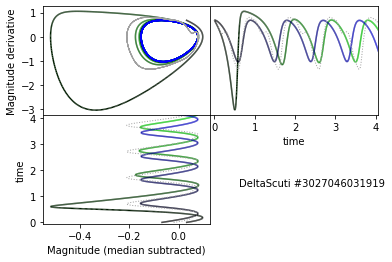

x' = 1.000 xdot
xdot' = 0.967 1 + -60.488 x + 41.882 x xdot + -6.959 xdot^2
nMSE: 2.3409706390563287


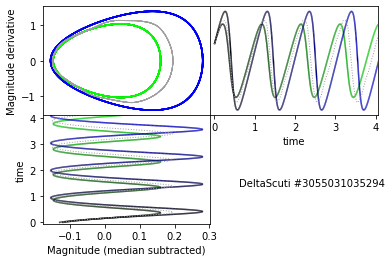

x' = 1.001 xdot
xdot' = -3.431 1 + -51.076 x + 5.436 xdot^2
nMSE: 3.958739489863399


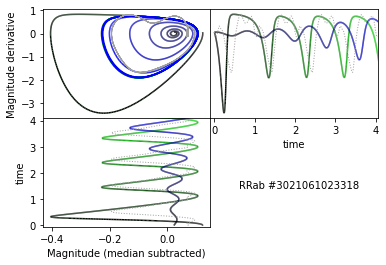

x' = 1.001 xdot
xdot' = 1.598 1 + -66.322 x + -0.164 xdot + 69.137 x xdot + -5.872 xdot^2
nMSE: 0.06087376178217611


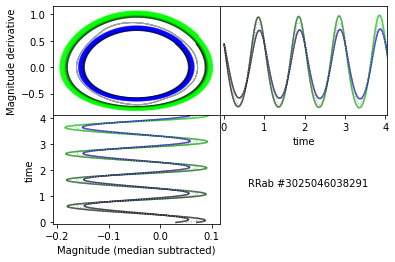

x' = 1.001 xdot
xdot' = -1.827 1 + -39.783 x + -0.742 xdot + -16.607 x xdot
nMSE: 1.4357556802889446


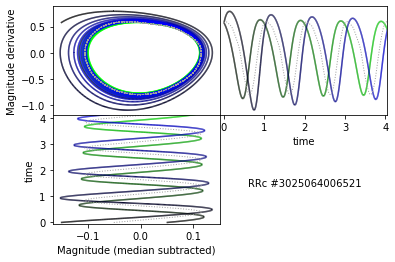

x' = 0.999 xdot
xdot' = 1.080 1 + -41.672 x + -0.505 xdot + 26.478 x xdot + -2.737 xdot^2
nMSE: 2.867294082721838


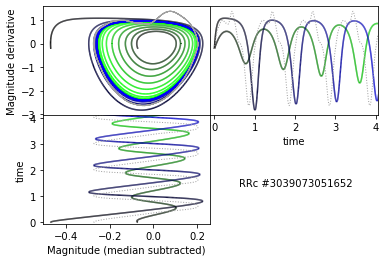

x' = 1.001 xdot
xdot' = 0.689 1 + -47.429 x + -0.047 xdot + 41.379 x xdot + -1.245 xdot^2


In [34]:
model, nMSE, t1, X1, s = sindyfy_lasso("./DeltaScuti9/3027046031919.csv", True, 0.01, 2, [0.05,0], silent=True, many=True)
model.print()
model, nMSE, t2, X2, s = sindyfy_lasso("./DeltaScuti9/3055031035294.csv", True, 0.01, 2, [0.005,0], silent=True, many=True)
model.print()
model, nMSE, t3, X3, s = sindyfy_lasso("./RRab1/3021061023318.csv", True, 0.01, 2, [0.05,0.0], silent=True, many=True)
model.print()
model, nMSE, t4, X4, s = sindyfy_lasso("./RRab1/3025046038291.csv", True, 0.01, 2, [0.02,0.0], silent=True, many=True)
model.print()
model, nMSE, t5, X5, s = sindyfy_lasso("./RRc2/3025064006521.csv", True, 0.01, 2, [0.1,0.0], silent=True, many=True)
model.print()
model, nMSE, t6, X6, s = sindyfy_lasso("./RRc2/3039073051652.csv", True, 0.01, 2, [0.2,0.0], silent=True, many=True)
model.print()
plt.show()

nMSE: 0.13676808348809158
0.037055014392891696 0.06782442654718382 -0.035746307187701505 0.000286793330974403
nMSE: 0.34493608701328166
0.08564533930536003 0.21222758648483903 -0.10578466847397713 0.0024602116653257866
nMSE: 0.060390078482115396
0.09336587653858244 0.11175833479499142 -0.08749729739313362 0.001067741705793475
nMSE: 0.05073848311705181
0.0 0.0 0.10623618593837202 -0.0
x' = 1.001 xdot
xdot' = -3.431 1 + -51.076 x + 5.436 xdot^2


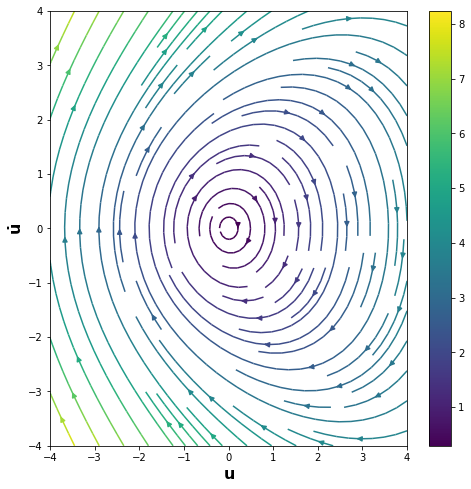

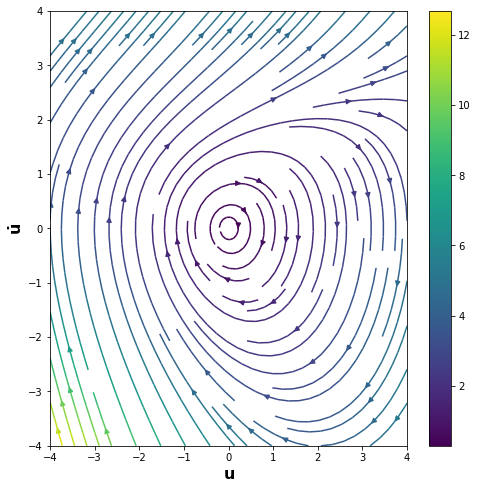

In [35]:
def calculateabc(filename, regularizations=[0.01,]):
    MSE = 1000.0
    MSEt = 1001.0
    for r in regularizations:
        try:
            modelt, MSEt, tt, Xt, st = sindyfy_lasso(filename, True, r, 2, [0,0], silent=True)
        except:
            pass
        if(MSEt < MSE):
            model = modelt
            MSE = MSEt
            t = tt
            X = Xt
            s = st
    if(MSE>=1000.0):
        print("Failed to fit this light curve!")
        return(np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
    A = model.coefficients()[0,2]
    B = model.coefficients()[1,0]
    C = -model.coefficients()[1,1]
    D = model.coefficients()[1,2]
    E = model.coefficients()[1,4]
    F = model.coefficients()[1,5]
    omega = np.sqrt(A*C)
    a = (D + (E*B/C))/omega
    b =  E/(A*C*omega) #did it have a minus sign or not?
    c =  F/(C*A*A) #did it have a minus sign or not?
    amplitude = (a*b+2*c)*(b+a*c)/(4.0*(a*a-4)) 
    return(a, b, c, amplitude, MSE, omega, model, t, X, s, filename)

def phasePlot(a, b, c):
    x, y = np.meshgrid(np.linspace(-4, 4, 20),
                   np.linspace(-4, 4, 20))

    u = y
    v = -x +a*y + b*x*y + c*y*y

    plt.figure(figsize=(8, 8))
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    mag = norm(np.dstack([u, v]), axis=-1)
    plt.streamplot(x, y, u, v, color=mag, cmap='viridis')
    plt.colorbar()
    plt.xlabel(r"$\mathbf{u}$", fontsize=16)
    plt.ylabel(r"$\mathbf{\dot{u}}$", fontsize=16)

    plt.show()    

a, b, c, amplitude, MSE, omega, model, t, X, s, star  = calculateabc("./RRc2/3021091024114.csv")
print(a,b,c,amplitude)
a, b, c, amplitude, MSE, omega, model, t, X, s, star  = calculateabc("./DeltaScuti9/3033094036811.csv")
print(a,b,c,amplitude)
a, b, c, amplitude, MSE, omega, model, t, X, s, star  = calculateabc("./DeltaScuti9/3035060033188.csv")
print(a,b,c,amplitude)
a, b, c, amplitude, MSE, omega, model, t, X, s, star  = calculateabc("./DeltaScuti9/3055031035294.csv")
print(a,b,c,amplitude)

model.print()
phasePlot(0,0,0.2)
phasePlot(-0.01,0.25,0.25)



nMSE: 1.1942090276448087
Could not fit star ./RRc2/3023099005903.csv.


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 24.51568920405888
nMSE: 3.7566024231967186
nMSE: 0.4295181628406349
nMSE: 2.677734304010903
nMSE: 10.58596729617773
Could not fit star ./RRc2/3025018007797.csv.
nMSE: 0.248824908935214


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1936139332326332


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
nMSE: 0.35522884104354574
nMSE: 0.3916830706796032
nMSE: 0.01752721092499505
nMSE: 0.01752721092499505


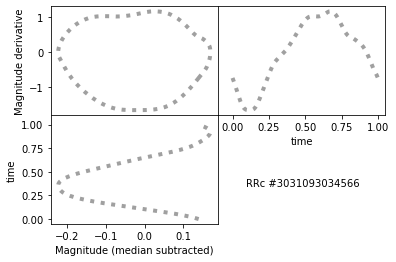

nMSE: 1.3950507390011575


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 57618.91589696489
nMSE: 0.01412958602975061
nMSE: 0.01412958602975061


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 9780.785839973718


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 924.1685774349069
nMSE: 1.0091684944608732
nMSE: 1.4832646580996187


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 524.6547123826118
nMSE: 1.069786363768314
nMSE: 1.3950507390011575
nMSE: 1.2478103641181197
nMSE: 6.104990728924262
nMSE: 0.32051562485416113
nMSE: 1.0747265388545206
nMSE: 0.3304524946272755
nMSE: 1.3442074923921399
Could not fit star ./RRc2/3037068056924.csv.
nMSE: 1.2616223490206948
nMSE: 0.13676808348809158
nMSE: 0.13676808348809158


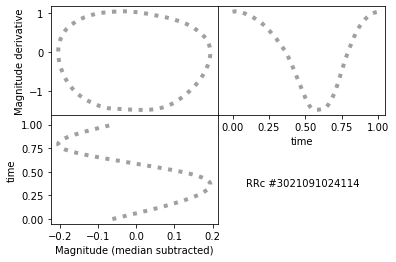

nMSE: 1.2664359547196726
nMSE: 1.1091687392555634
nMSE: 0.144727808040622
nMSE: 0.144727808040622


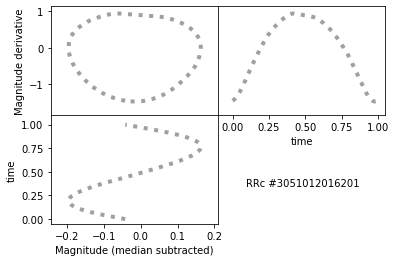

/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-33-1184194c0d60>:117: RuntimeWarning: overflow encountered in multiply
  nMSE = np.mean(delta_magnitude*delta_magnitude)/np.mean(delta_magnitude_from_median*delta_magnitude_from_median) #MSE / MSE of predicting 0


nMSE: inf
nMSE: 0.9380466307347971
nMSE: 0.5770812136716887
nMSE: 1.271695305337976
nMSE: 0.038423867970816684
nMSE: 0.038423867970816684


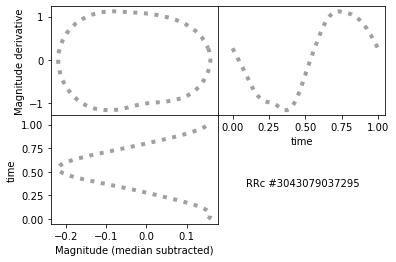

/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.135183947144926
nMSE: 0.992690000637188
nMSE: 1.8841550488128356
nMSE: 0.26267631700498634
nMSE: 1.0688865375331156
nMSE: 53523.93576297229


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
nMSE: 0.14293094902567618
nMSE: 0.14293094902567618


nMSE: 1.2598212205087564
nMSE: 1.5348620161903157
nMSE: 0.015586634269764548
nMSE: 0.015586634269764548


nMSE: 1.1213347710555952
nMSE: 2.6219360686294357
nMSE: 0.012030056134834157
nMSE: 0.012030056134834157


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-27c6953c717a>", line 47, in <module>
    model, nMSE, t, X, s = sindyfy_lasso(star, True, 0.01, 2, [0,0], silent=False)
  File "<ipython-input-33-1184194c0d60>", line 121, in sindyfy_lasso
    showTheCurves(t, X, s, star)
  File "<ipython-input-33-1184194c0d60>", line 96, in showTheCurves
    plt.show()
  File "/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/matplotlib/pyplot.py", line 353, in show
    return _backend_mod.show(*args, **kwargs)
  File "/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py", line 41, in show
    display(
  File "/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/IPython/core/display.py", line 313, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
 


KeyboardInterrupt



In [36]:
ds = ([os.path.join("./DeltaScuti9", f) for f in os.listdir("./DeltaScuti9")])
rrc = ([os.path.join("./RRc2", f) for f in os.listdir("./RRc2")])
rrab = ([os.path.join("./RRab1", f) for f in os.listdir("./RRab1")])
someStars = [*ds, *rrc, *rrab]


#i = 0
#while (i < 8):
#    star = np.random.choice(ds)
#    nMSE = 1000
#    try:
#        model, nMSE, t, X, s = sindyfy_lasso(star, True, 0.01, 2, [0,0], silent=True)
#    except:
#        print("Could not fit star " + star + ".")
#        nMSE = 1000
#    if(nMSE < 0.16):
#        i = i+1
#        model, nMSE, t, X, s = sindyfy_lasso(star, True, 0.01, 2, [0,0], silent=False)

        
        
#i = 0
#while (i < 8):
#    star = np.random.choice(rrab)
#    nMSE = 1000
#    try:
#        model, nMSE, t, X, s = sindyfy_lasso(star, True, 0.01, 2, [0,0], silent=True)
#    except:
#        print("Could not fit star " + star + ".")
#        nMSE = 1000
#    if(nMSE < 0.16):
#        i = i+1
#        model, nMSE, t, X, s = sindyfy_lasso(star, True, 0.01, 2, [0,0], silent=False)
        

i = 0
while (i < 8):
    star = np.random.choice(rrc)
    nMSE = 1000
    try:
        model, nMSE, t, X, s = sindyfy_lasso(star, True, 0.01, 2, [0,0], silent=True)
    except:
        print("Could not fit star " + star + ".")
        nMSE = 1000
    if(nMSE < 0.16):
        i = i+1
        model, nMSE, t, X, s = sindyfy_lasso(star, True, 0.01, 2, [0,0], silent=False)



In [37]:
bef = time.perf_counter()
ds = [os.path.join("./DeltaScuti9", f) for f in os.listdir("./DeltaScuti9")]
rrc = [os.path.join("./RRc2", f) for f in os.listdir("./RRc2")]
rrab = [os.path.join("./RRab1", f) for f in os.listdir("./RRab1")]
someStars = [*ds, *rrc, *rrab]
labels = [*np.repeat(0, len(ds)), *np.repeat(1, len(rrc)), *np.repeat(2, len(rrab))]
abcs = [calculateabc(filename) for filename in someStars]
af = time.perf_counter()
print(af - bef)

/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 319.0788159448764


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-35-524b4711ce82>:25: RuntimeWarning: divide by zero encountered in double_scalars
  a = (D + (E*B/C))/omega
<ipython-input-35-524b4711ce82>:26: RuntimeWarning: divide by zero encountered in double_scalars
  b =  E/(A*C*omega) #did it have a minus sign or not?
<ipython-input-35-524b4711ce82>:27: RuntimeWarning: divide by zero encountered in double_scalars
  c =  F/(C*A*A) #did it have a minus sign or not?
<ipython-input-35-524b4711ce82>:28: RuntimeWarning: invalid value encountered in double_scalars
  amplitude = (a*b+2*c)*(b+a*c)/(4.0*(a*a-4))


nMSE: 0.9059895718978183
nMSE: 0.5491844228320863
nMSE: 0.34049391856105116
nMSE: 4.721303473187333
nMSE: 0.5040114925127895
nMSE: 1.085171888032819
nMSE: 1.478985764094463
nMSE: 0.15319215562846536
nMSE: 1.0821168101278953
nMSE: 0.6729729457104163
nMSE: 0.1556456939070808


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0046841068700625


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 535.7568565204582
nMSE: 0.6139820136809235
nMSE: 0.24535953680472106


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9979760625207927
nMSE: 12822.332119798286
Failed to fit this light curve!
nMSE: 2.208420987173775
nMSE: 0.24060247267097343
nMSE: 1.011956694112695
nMSE: 1.835258896896237
nMSE: 0.9987749060774405


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.097584906564773
nMSE: 1.5017103853938498
nMSE: 0.984665508472679
nMSE: 1.1597732334446944
nMSE: 0.6957428389791361
nMSE: 1.43502021147734
nMSE: 0.00511708409147372
nMSE: 1.0977715974039406
nMSE: 0.5063523004070987
nMSE: 0.004191538813160519
nMSE: 6.439845677436724
nMSE: 0.19351356975915196
nMSE: 1.1202550270203997
nMSE: 2.113891856055214
nMSE: 0.6972670938936399
nMSE: 1.2946194879050321
nMSE: 2.3051381675175624
nMSE: 0.07960514359752163
nMSE: 0.34493608701328166
nMSE: 0.1648394256939563
nMSE: 0.8192968199167249
nMSE: 1.1295852698517848
nMSE: 0.9956560075603096


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 0.6805738484038331
nMSE: 1.750626039780203
nMSE: 0.060390078482115396
nMSE: 1.105826359866939
nMSE: 185586.88528284262
Failed to fit this light curve!
nMSE: 3.137726423988404


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2052.019412993403
Failed to fit this light curve!
nMSE: 30.769584871990666
nMSE: 0.2791587820622315
nMSE: 1.2105092214501534
nMSE: 1.8762718628708956
nMSE: 1.8530023546297356
nMSE: 0.9627313548151399
nMSE: 1.1692156537511433
nMSE: 0.08229325317913097
nMSE: 46.53701727820602
nMSE: 0.003514111209225547


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0152193598743005
nMSE: 1.3506870822272155


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 0.27875860963807436
nMSE: 3.578432194364142
nMSE: 1.2545650589952673
nMSE: 1.0049797794615187
nMSE: 4.626324009658893
nMSE: 1.026208875087031
nMSE: 2.8000607683142507
nMSE: 1.6050691740266863
nMSE: 0.23276208828444508
nMSE: 32066.76235085874
Failed to fit this light curve!
nMSE: 132077.71250440553
Failed to fit this light curve!
nMSE: 0.4121226693727593
nMSE: 593524.5075991973
Failed to fit this light curve!
nMSE: 1.2167444599711421
nMSE: 1.3086260771611549


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.54049474852825
nMSE: 0.7162456669849278
nMSE: 3.3016826517040494
nMSE: 1.4379255421448698
nMSE: 1.9216306058776116
nMSE: 1.1960737660497862


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.1586535334324994
nMSE: 0.9706462899894662
nMSE: 0.06611169007549762


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1412189444.1053674
Failed to fit this light curve!
nMSE: 0.05073848311705181
nMSE: 1.0023545844709423
nMSE: 1.0003074965250212
nMSE: 0.9974323757291664
nMSE: 1.0508914264436695
nMSE: 1.0001922215047987
nMSE: 1.06687987997498
nMSE: 1.4947804270994518
nMSE: 1.0465641934865726


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9837280756027746
nMSE: 1.0039181048868726
nMSE: 7.096676238052839
nMSE: 1.0179423066398297
nMSE: 0.4094354962011342
nMSE: 2.634276761990026
nMSE: 1.5554614067776433
nMSE: 4964186.515499667
Failed to fit this light curve!
nMSE: 3.6505595561925355
nMSE: 1.4969329046649351


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.014307557718905182
nMSE: 0.07175441818969794
nMSE: 1.453085979533863


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 4.477995457918943
nMSE: 1.2324969970785808
nMSE: 4.977498017533074
nMSE: 0.08462446054547272
nMSE: 2.8618797360101222


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 855.1399153879494
nMSE: 2.11829801207974
nMSE: 1.0031568250522476


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 324.77545943106355
nMSE: 1.0097624862674386
nMSE: 0.8654561888270195
nMSE: 0.2923723963522202
nMSE: 1.166959124607248
nMSE: 0.5340893364721045


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 774485.3472810042
Failed to fit this light curve!
nMSE: 1.0301637642682124
nMSE: 22.558313047997224
nMSE: 0.8316283028379842


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0102402078436672
nMSE: 1.6371461729509307
nMSE: 0.46787076432464303
nMSE: 1.5825844450439777
nMSE: 1.2743766399945446
nMSE: 0.9987399013607432
nMSE: 1034.3841211760653
Failed to fit this light curve!
nMSE: 1.2950160777194157
nMSE: 0.3531861747380667


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 9.397374528868809e+86
Failed to fit this light curve!
nMSE: 1.203253360511828


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 121.60247778119968
nMSE: 0.6930387178685894
nMSE: 0.8480960069881159


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1055804264356797
nMSE: 0.9991956693958164
nMSE: 1.643705901272836
nMSE: 1.4263725277927002
nMSE: 1.4832646580996187
nMSE: 0.13676808348809158
nMSE: 0.8458101466083952


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 197.75368640945624
nMSE: 1.121794949937844
nMSE: 0.4374488692164448
nMSE: 1.2070928886677963
nMSE: 2.0723210000350285
nMSE: 242628724.18887204
Failed to fit this light curve!
nMSE: 0.020983897899143657
nMSE: 0.1077593261512721
nMSE: 1.0108757729253943


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3228201220.5306516
Failed to fit this light curve!
nMSE: 0.992690000637188
nMSE: 2276.1413474143096
Failed to fit this light curve!
nMSE: 1.2109045468774824
nMSE: 0.9974994193186112
nMSE: 0.3384991624557681
nMSE: 12.574306820348657


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2.015276297617089
nMSE: 1.9186734701962207


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9545599072291306
nMSE: 1.182125054932601
nMSE: 13.038966204349729
nMSE: 1.32188249338949


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 194.06284141023906
nMSE: 1280.044437729389
Failed to fit this light curve!
nMSE: 0.535948124800522
nMSE: 1.0465396945867949
nMSE: 1.0618412793873875
nMSE: 3.7504015355099782
nMSE: 0.12558763465601247
nMSE: 1.820238613708141
nMSE: 0.017894138050041492
nMSE: 1.716291533775603


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 761.0855757426772


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1699398041145845
nMSE: 0.16093155302045126
nMSE: 1.3738877459461873


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 45.36290550066196
nMSE: 0.19795911975862304
nMSE: 1.2464918074847393


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 41.13640870151625
nMSE: 0.2278212378940126
nMSE: 1.1408731851347038


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.0055048893246328


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.3190224525344314
nMSE: 1.7546039540932716
nMSE: 2.380701714661304
nMSE: 1.568988599287536
nMSE: 0.21339357104807072
nMSE: 0.7910754796722427


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 18111.78308019492
Failed to fit this light curve!
nMSE: 324.9079298189917


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 26.821252935259626
nMSE: 5.509921086946368
nMSE: 2.9295956994989556
nMSE: 24.972066722275322


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/numpy/core/_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.995362301059096
nMSE: 0.31094866765771556
nMSE: 0.01912733135676597
nMSE: 1.3345128824752521


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.9882629234567054
nMSE: 6.131872162517676
nMSE: 1.0000349339948522
nMSE: 0.8626375774856595
nMSE: 2.327233445642643


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 53567.492375906455
Failed to fit this light curve!
nMSE: 0.08196780566858582
nMSE: 1.0857868226389644
nMSE: 0.9449229656371829
nMSE: 0.011795007555031349


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 917.8924464151016
nMSE: 1.3045905704321765
nMSE: 329553.6487456321
Failed to fit this light curve!
nMSE: 1.009467272822502


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 35.1521007146744
nMSE: 0.9984775397231516
nMSE: 0.00019487127285986654
nMSE: 0.07491292555321812
nMSE: 2044984.8395406124
Failed to fit this light curve!
nMSE: 0.03446281299375796


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.9895413324538539
nMSE: 1.000951931437087
nMSE: 0.8582353772896332


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 166.9025924662347
nMSE: 3.46374177234574


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 43.563739927049845
nMSE: 23197.846686160017
Failed to fit this light curve!
nMSE: 1.2383295305086162
nMSE: 0.2840038331264114
nMSE: 0.25928491979153656
nMSE: 8.36986260076392
nMSE: 718.7439244219462
nMSE: 0.03778245140017566


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 15.199314122443687


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 60.45151200629198
nMSE: 5.342158608918465
nMSE: 1.009236510466329
nMSE: 1.0813922632312398
nMSE: 1.0067302104344618


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.047235100648732736
nMSE: 1.5318410846581423
nMSE: 1.0371004597836717


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0434846595744507


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 44.56962933953724
nMSE: 3.920415361974609
nMSE: 2.625590592840113
nMSE: 3.364098595122277
nMSE: 0.012030056134834157
nMSE: 1.0863139607142298


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 26.774700515742644


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 241.790053423246


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 7.113903764350749e+19
Failed to fit this light curve!
nMSE: 2.6866783092052904
nMSE: 1.6917684878950427


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 19.02114966746898
nMSE: 2.553324882280243


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 4.1236889954869795
nMSE: 1.0048910876814907
nMSE: 0.10389486057010017


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 44.82295037779393


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 140.70721414389462
nMSE: 1.5203079083772866
nMSE: 1.01348188698451
nMSE: 0.2121180378715773
nMSE: 2.9436672986572705
nMSE: 1.1073109734436748
nMSE: 0.05536487543091122
nMSE: 27.27404843864241


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.2879880183979713


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0906312785355958
nMSE: 2.9450656638785193


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 169.3426279325646


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1723.8932583469427
Failed to fit this light curve!
nMSE: 1.5806057221350056
nMSE: 1.3853613368572242
nMSE: 16873.202965677196
Failed to fit this light curve!
nMSE: 1.5398704381699968
nMSE: 0.9958501519051428
nMSE: 0.2330372905011986
nMSE: 0.07392632394432688
nMSE: 2.9437030254881633
nMSE: 144.93960751511898
nMSE: 0.9995832902574499
nMSE: 0.021899278392467737


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 53128.80360495905
Failed to fit this light curve!
nMSE: 0.9995361206286517
nMSE: 0.9092115689763987
nMSE: 4.395788167310517


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.9717298451978379
nMSE: 0.018451486195493173
nMSE: 1.284228502896635
nMSE: 0.7156381802279619
nMSE: 1.0073458735139849
nMSE: 0.23861064546635558
nMSE: 92.66427654747044
nMSE: 47.27202146453339
nMSE: 159.842534135809
nMSE: 1.3909284949583864
nMSE: 1.1084498680298849


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 13.72282097043349
nMSE: 3.9603385245044027
nMSE: 0.9328509893937875
nMSE: 8.061074563229923
nMSE: 1.0211950253692834


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0481463622184108
nMSE: 5.661495087009422
nMSE: 3.0122379857895822


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 6010.250675202541
Failed to fit this light curve!
nMSE: 0.0007362263487476654
nMSE: 0.012920168365502024
nMSE: 0.8561595753951615
nMSE: 1.1213347710555952


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0036597928879984
nMSE: 0.7791416015213658
nMSE: 0.9994095220128343
nMSE: 0.16798556053700878
nMSE: 0.9986302467105398
nMSE: 1.3567404580777445
nMSE: 1.5389928932305017
nMSE: 0.6388106111973069
nMSE: 4.615934023791279
nMSE: 0.44275641673134125
nMSE: 0.9155492416735197
nMSE: 1.2702880347498156
nMSE: 1.2970417730189616
nMSE: 0.1143037866466123
nMSE: 0.4912666328512493


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0445643141260574
nMSE: 1.1648590029035988
nMSE: 0.8555538292241981


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 614.8762993688175
nMSE: 0.03350086951271126
nMSE: 1.000231529603668
nMSE: 4.9102424303217065


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 6289573138.050636
Failed to fit this light curve!
nMSE: 0.0005908182462185778
nMSE: 0.03969674295314717


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 171.41568616301626
nMSE: 1679718.0909660559
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 15441077.975830965
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 675.0526076265028
nMSE: 1.4778057101264235


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.0259519952077851
nMSE: 0.3348138164684937
nMSE: 1.201064574891571
nMSE: 29.439800232140477
nMSE: 1.5616345723418728
nMSE: 0.03138233295135793
nMSE: 1.4434110907973612


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 63075.66937925564
Failed to fit this light curve!
nMSE: 1.004225189315503


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 44550563103.17623
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0049253521876902
nMSE: 2.9201108564418536
nMSE: 0.9970433596288716
nMSE: 1.427765436310773
nMSE: 0.3606781246893052
nMSE: 1.3297938998755876
nMSE: 1.0025324998381118
nMSE: 1.294669613269284
nMSE: 0.018882350141078672
nMSE: 1.057926970039151
nMSE: 1.003740119559773
nMSE: 1.4286424471226815
nMSE: 1.834901757765864
nMSE: 1.291989779674444
nMSE: 0.17010141268806317
nMSE: 1.2345728325512002
nMSE: 1.9584768527594263
nMSE: 1.0869319864792824


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0860981983905817
nMSE: 190762.53616513326
Failed to fit this light curve!
nMSE: 1.703826342696714
nMSE: 1.0001742397819477


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 27205601087.63667
Failed to fit this light curve!
nMSE: 2.9620999420828324


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.2739627986446533
nMSE: 1.0005390998355426
nMSE: 119.86531945667905
nMSE: 0.9973309869257043
nMSE: 2.189992941268991
nMSE: 4.6906898148463325


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 91.28118470644777
nMSE: 0.028043309814836492
nMSE: 0.028636263537728846
nMSE: 0.1509027993936904


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2102.1009880900892
Failed to fit this light curve!
nMSE: 0.4010000018760978
nMSE: 0.11378546486854263


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 45.595235368195866
nMSE: 0.46570815890980893
nMSE: 1.3950507390011575
nMSE: 0.25703056690828485
nMSE: 628655.9172646444
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 37163.46149349603
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 6.750841748441972
nMSE: 4.0775578521346585
nMSE: 0.05442359311981255
nMSE: 1194220.1162918727
Failed to fit this light curve!
nMSE: 872975.8194504561
Failed to fit this light curve!
nMSE: 1.5281935288648398
nMSE: 2.2661739041827187
nMSE: 1.9343233185689452
nMSE: 0.09782946918119788
nMSE: 0.9959075698599222


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 4577.815572662241
Failed to fit this light curve!
nMSE: 1.8312858755646642
nMSE: 10.58596729617773
nMSE: 1.0143392640791145
nMSE: 28750.416384392043
Failed to fit this light curve!
nMSE: 2891.598976555474
Failed to fit this light curve!
nMSE: 1.7952173960080486
nMSE: 1.7481514929142146


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 108.41900411751568
nMSE: 1.464016599272991
nMSE: 1.7871289516936542
nMSE: 0.24393556136953032


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0021011176960466


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.016558644796142
nMSE: 0.1867889780968964
nMSE: 2.4618218597358656
nMSE: 2.0674938856838954


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 3.4362607099701217


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0504023500497262


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0296447472045867
nMSE: 0.02533748281008964
nMSE: 1.2263450330063093
nMSE: 1.4117639552074968


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1427490335061758
nMSE: 1.4404170577052295
nMSE: 0.06360286882525767
nMSE: 0.2347887915396407
nMSE: 0.9487996727642863
nMSE: 3.7566024231967186
nMSE: 8324580.96933494
Failed to fit this light curve!
nMSE: 0.33001992053017154
nMSE: 1.005950646814928


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 95080880.78398246
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3316.981049864764
Failed to fit this light curve!
nMSE: 0.08999338807460518
nMSE: 2.402425345080607
nMSE: 0.05361267667207083


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.29201735724082256
nMSE: 1.1123747558098087
nMSE: 1.1613431568828743
nMSE: 1.0715929813996152
nMSE: 8.068851654261822
nMSE: 1.328060604758348


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0017756915494513
nMSE: 878834.380953512
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 42.91850682882729
nMSE: 3.3740947204410747


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 155.9880218467619
nMSE: 2.825000734967641


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0877611105872191


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1201796.765418855
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 884927.6747931509
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 749.8640953411066
nMSE: 0.7599787052775563
nMSE: 1.383729020254186


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0895891450038648
nMSE: 63.52685742545511
nMSE: 1.271824160256396


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 9149.234718352482
Failed to fit this light curve!
nMSE: 0.961698934382608
nMSE: 3.9988970596762856
nMSE: 1.0001923997408175


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.8586762157781196
nMSE: 0.06532411698298904


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 5.157851769315621
nMSE: 3.2012721562505155
nMSE: 24421.35135216202
Failed to fit this light curve!
nMSE: 1.1128824627472342
nMSE: 3.019653824116183
nMSE: 1.992804910276


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 37856731791.85116
Failed to fit this light curve!
nMSE: 1.0009786401387928
nMSE: 0.8681716803152757
nMSE: 1.2226605016673275
nMSE: 606.6154755790923
nMSE: 0.08416189172031259
nMSE: 0.10789696015014608
nMSE: 2.952768142416413
nMSE: 1.392320223018105
nMSE: 0.8491483949095718
nMSE: 0.7403824254422321
nMSE: 0.07899199754565203
nMSE: 0.8208953643356524
nMSE: 1.0005871172698464
nMSE: 29.8866468387821
nMSE: 1.0006103594191589
nMSE: 0.2676497167404307
nMSE: 0.9885525955993022


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.2616223490206948
nMSE: 0.08554375842973533
nMSE: 2.4812224677333443
nMSE: 0.5300448347927847


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.6522722092943563


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 236.91916361600428
nMSE: 24.365384638950857


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1551152323112648


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1552249.7622746085
Failed to fit this light curve!
nMSE: 22.550042461978933
nMSE: 0.8964344264385404
nMSE: 26583.936386342873
Failed to fit this light curve!
nMSE: 0.5757758777909437
nMSE: 432.0114560279666
nMSE: 1.033306123072788
nMSE: 4.337635244552145
nMSE: 1.0640088393585363
nMSE: 34162.351873966545
Failed to fit this light curve!
nMSE: 0.3544789292549869


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 120.0716318848198


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.000630685913353
nMSE: 4.240506989515422


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.551402433036949
nMSE: 2.257349110621881
nMSE: 0.4991063562644392
nMSE: 0.5343554315613347
nMSE: 1.3163368896612195
nMSE: 0.020118635040818476
nMSE: 0.03199032525620264
nMSE: 1.8876188013544766
nMSE: 3569.0337231825947
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.027774192544938
nMSE: 0.26685415381152683
nMSE: 2.003492488294678e+84
Failed to fit this light curve!
nMSE: 1.1159420742822062
nMSE: 0.1320500775680583
nMSE: 2.7208651568801865
nMSE: 1.3004355293209315
nMSE: 4.6271797101947865
nMSE: 1.111536834911101


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0554172329372165


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.3230849934407838
nMSE: 0.060955500335615656
nMSE: 3.699702154882975e+77
Failed to fit this light curve!
nMSE: 0.3304524946272755
nMSE: 0.9913613052655056
nMSE: 0.0003672647102750613
nMSE: 0.021658655853022516
nMSE: 0.006387760930537323
nMSE: 1.2522883307139285


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0083712135816587


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.22446456585486463
nMSE: 0.003419807486231005


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1853379.45540223
Failed to fit this light curve!
nMSE: 0.3503557019404785
nMSE: 1.4503309906364734
nMSE: 3.1432083566672615
nMSE: 0.33148787648776407


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0433054814706142
nMSE: 1.0195775051432132


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.022058813898557
nMSE: 0.7979176495623118
nMSE: 0.01488474019382624


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0075675058824112
nMSE: 5.554379350655194


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.04482827186594
nMSE: 1.0062773148545987
nMSE: 2.722392649174826
nMSE: 1.5125595275980617
nMSE: 1.6960342757812406
nMSE: 1.0025652743666318
nMSE: 0.9672117090676831


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.3221818577491982
nMSE: 1.106452311900048
nMSE: 1.5400482535803481
nMSE: 42.474063338473655


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 973.3623256029748
nMSE: 3.10679265089443
nMSE: 0.35522884104354574
nMSE: 0.10337965150283454
nMSE: 17551.18801297697
Failed to fit this light curve!
nMSE: 4.457799799508067
nMSE: 1.3398104079939037


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 22019.420460476817
Failed to fit this light curve!
nMSE: 0.9821233739931803
nMSE: 0.0020835980297682355
nMSE: 1.2261931015968288
nMSE: 1.13481095446443


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0437956315934116
nMSE: 0.06546566088669101


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0210380638990941
nMSE: 2.9829408939269513


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 4410.071003919665
Failed to fit this light curve!
nMSE: 1.5263810660862587
nMSE: 13861.045652076571
Failed to fit this light curve!
nMSE: 0.19106947077864503
nMSE: 0.5483146640225107
nMSE: 0.016982948844849088
nMSE: 0.5071032351307397
nMSE: 3.192585843377268
nMSE: 1.3104730416451584
nMSE: 5.128695551013137
nMSE: 1.396458237538921
nMSE: 0.00872626429358406


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1513.941937051017
Failed to fit this light curve!
nMSE: 1.5621666561077354
nMSE: 0.009527985191063158
nMSE: 1.1101699437611297
nMSE: 0.19807897702138919
nMSE: 2.448274616679291
nMSE: 0.9705561149060178
nMSE: 5.171448129123522
nMSE: 1.044484596299303


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 8.411511012871951
nMSE: 0.01752721092499505
nMSE: 1.2454320184761027
nMSE: 0.06361825024367052
nMSE: 0.001391125492673235


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.1566588781361686
nMSE: 0.763907568381594
nMSE: 0.14331874236373626


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-33-1184194c0d60>:117: RuntimeWarning: overflow encountered in multiply
  nMSE = np.mean(delta_magnitude*delta_magnitude)/np.mean(delta_magnitude_from_median*delta_magnitude_from_median) #MSE / MSE of predicting 0


nMSE: nan
Failed to fit this light curve!
nMSE: 103.82819520829547
nMSE: 0.3085762096426042
nMSE: 0.0008711709919149941
nMSE: 0.5770812136716887
nMSE: 5.283278203147066


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1788747248563558


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1046050539075285
nMSE: 6.2882859599389285
nMSE: 1.0320981369211273
nMSE: 0.8017840743256308
nMSE: 1.8537376526776115


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0244736036063178
nMSE: 27.105932837108675


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.2478103641181197
nMSE: 1.5153117260259303
nMSE: 1.0695295028111358
nMSE: 0.003415692323206689
nMSE: 0.045122017004615364


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0570197284142773
nMSE: 12738.827241294035
Failed to fit this light curve!
nMSE: 0.026330202994102735
nMSE: 0.1599183044806914
nMSE: 0.017985599153652422


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.1303927076660003
nMSE: 1.317622270177099
nMSE: 1.1497591963240668
nMSE: 1.3817514065631764
nMSE: 1.0081593455763915
nMSE: 1.9300561360432915
nMSE: 37.98658477670379


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 35.42020127818435


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 181.0927586255063


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0565613829835283
nMSE: 0.9715722216975429
nMSE: 0.8399265237981843
nMSE: 1.1091687392555634


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/numpy/core/_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


Failed to fit this light curve!
nMSE: 6.104990728924262


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 173.5953573671962
nMSE: 1.105640678194377


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0375586392666336
nMSE: 0.5863195040366971
nMSE: 1.6694602719585172
nMSE: 1.1380236590090327
nMSE: 0.06810426001175877
nMSE: 0.20457958080486902


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3107.4944928100917
Failed to fit this light curve!
nMSE: 0.47021167401241276
nMSE: 2.0656378218311016
nMSE: 0.6002369536124147


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0630905425928714


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 9643671534.556652
Failed to fit this light curve!
nMSE: 1.7531361040701443


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0853015255292116
nMSE: 2.440375244896196


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1214333028295784
nMSE: 3.0551841949624583
nMSE: 3.869736000870227
nMSE: 1.982779501631892


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 0.07285743693454086


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 9220273616.127653
Failed to fit this light curve!
nMSE: 0.3017839666644749
nMSE: 1.541255061425891
nMSE: 1.1551520413210143
nMSE: 0.3700841493813384
nMSE: 0.2464201004190579
nMSE: 2.2072986592794206
nMSE: 1.2795999362313082
nMSE: 1.0680756087384453
nMSE: 0.9784412399825206


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 4962.304620026304
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 4038.4900997950544
Failed to fit this light curve!
nMSE: 0.5234541148465333


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.17849656477516


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.2633878089870862
nMSE: 0.07757976652795132
nMSE: 0.24081435888061978
nMSE: 0.1315096838404263
nMSE: 1.0966929058238828
nMSE: 1.484535503276788
nMSE: 4.475405298569338e+142
Failed to fit this light curve!
nMSE: 0.7182894477022851
nMSE: 2.4953289482718905e+80
Failed to fit this light curve!
nMSE: 1.658865694585959
nMSE: 1.0919672079856217
nMSE: 0.25882603907696267
nMSE: 1.9111249788430247


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1006014667036685
nMSE: 0.5475535949971958


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0725561821420162


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 299.0208891269562


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 33.53854893082513


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.076789089058227


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0792981993812651
nMSE: 1.856385719329487
nMSE: 0.010389468867579424
nMSE: 0.15897414885295996
nMSE: 1.0659468436332393
nMSE: 0.9996828211947976


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 5101.980781600184
Failed to fit this light curve!
nMSE: 1.7617137200634652
nMSE: 0.8826857438878322
nMSE: 15685116.372129567
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.006585461876357891
nMSE: 1.406083960589912e+80
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2.0783603448110797e+80
Failed to fit this light curve!
nMSE: 0.10593846647204247
nMSE: 0.9380466307347971
nMSE: 1.5741201767288135
nMSE: 0.4216827496645399
nMSE: 1.4327496564184659
nMSE: 0.7345391167722887
nMSE: 1.1582380790887417
nMSE: 0.9970407432135581


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0044007243618047
nMSE: 6.8836550020018175
nMSE: 6.858945333577031
nMSE: 0.9021313685175255
nMSE: 0.39181707625224144
nMSE: 1.359416845497843
nMSE: 2.987334168785183e+91
Failed to fit this light curve!
nMSE: 0.10376806127831857
nMSE: 1.4233227108123543
nMSE: 0.17778811559994523
nMSE: 4.942499761116325e+79
Failed to fit this light curve!
nMSE: 1117769.748868991
Failed to fit this light curve!
nMSE: 0.4295181628406349


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 33.63696618874396


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 6471.648591644383
Failed to fit this light curve!
nMSE: 2953.0705402255926
Failed to fit this light curve!
nMSE: 3.1673713719735788
nMSE: 1.069786363768314
nMSE: 3.9573636143773494
nMSE: 1.0020486782192777
nMSE: 1.0938132626281056
nMSE: 0.3303036938503238


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.8739796359592589
nMSE: 0.1042944423594803
nMSE: 1.295044040967474
nMSE: 0.11847097100697021
nMSE: 6692.136534133848
Failed to fit this light curve!
nMSE: 4.717434676545958
nMSE: 0.007459084725383497
nMSE: 0.01412958602975061
nMSE: 1.3970055123078613
nMSE: 5052.325358339345
Failed to fit this light curve!
nMSE: 1.1654582227569716
nMSE: 1.9355786766326553
nMSE: 488077.97361796716
Failed to fit this light curve!
nMSE: 1.019130534638648
nMSE: 0.3028830535995665
nMSE: 16.957233512412728


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1170968524.0866609
Failed to fit this light curve!
nMSE: 1.9283817305618594
nMSE: 7674188.444942151
Failed to fit this light curve!
nMSE: 16701112.372387363
Failed to fit this light curve!
nMSE: 0.34859863775052985
nMSE: 1.8599916842973325
nMSE: 0.003679444479639438
nMSE: 0.054286852575335595
nMSE: 6.984244801322268


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.019169993553827


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1548282775955983


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 272418.69160411257
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.2241521108729505


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 44.042835065815936
nMSE: 0.052208085310678484
nMSE: 1.092763508261507
nMSE: 1.9363554126263882
nMSE: 1.1792922942779793
nMSE: 1.0558667573122147


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 5.083578044242324


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 187.0825606290302
nMSE: 0.45206102208987653
nMSE: 0.5353624068569879


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0340145212063785
nMSE: 1.1476012809844287
nMSE: 6.815425406336897
nMSE: 1.3456424476685258
nMSE: 1.0752306874152455
nMSE: 2.741279427958784
nMSE: 2.329376368152341


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 46.44355751934433
nMSE: 1.0490523250295312


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 9.442687615127876e+19
Failed to fit this light curve!
nMSE: 1.5348204992647403
nMSE: 0.16122886789827673
nMSE: 1.0989436676320068
nMSE: 80462.7869321312
Failed to fit this light curve!
nMSE: 3.977071217460561
nMSE: 0.0004783226799782762


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1400586588722255
nMSE: 1.8841550488128356
nMSE: 0.9406093044389606
nMSE: 3.777114841254395
nMSE: 3.9694056073254687


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.0688865375331156
nMSE: 2.059687049357475
nMSE: 0.9833296156837236
nMSE: 1.749254290493691
nMSE: 1.2664359547196726


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 484.64720354134636
nMSE: 0.055136283873554015
nMSE: 31.369804154597432
nMSE: 9.082098034340893
nMSE: 10217.748726445912
Failed to fit this light curve!
nMSE: 1.0986829490699566
nMSE: 1.6383178793182807


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 126328.0685529715
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 672007683.019221
Failed to fit this light curve!
nMSE: 1.0970744516288606


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1306756279.3940868
Failed to fit this light curve!
nMSE: 9007.309135679458
Failed to fit this light curve!
nMSE: 1.654874828273851
nMSE: 0.03802098459213446
nMSE: 1.271695305337976
nMSE: 1.7859845316432823
nMSE: 1.4210138908754413
nMSE: 1.254462520413239
nMSE: 0.9564026176440861
nMSE: 1.135471818415663
nMSE: 0.3574399921141727
nMSE: 2.249117335144098
nMSE: 0.04511714866597228
nMSE: 0.9807428882510082
nMSE: 0.8264023970609538


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1591.3040447881117
Failed to fit this light curve!
nMSE: 10.915877840276734
nMSE: 1.0021682451513496
nMSE: 0.007114068991263543
nMSE: 0.23749779174187133
nMSE: 2.441280957399634


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 104387235501.86281
Failed to fit this light curve!
nMSE: 54.72581266390115
nMSE: 6.350345562631323
nMSE: 0.021342279925829752
nMSE: 0.5313843004925735
nMSE: 1.848746976173173
nMSE: 1.231519357745822


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0024550199672266
nMSE: 1.0860396861845285
nMSE: 131654.27991541647
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 331356514.8823133
Failed to fit this light curve!
nMSE: 0.8895716828067916
nMSE: 98297.70082929917
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 5324.446691613516
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1270900628076383
nMSE: 0.13325074172311607
nMSE: 1.4493961962913615
nMSE: 0.08144485190942324


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 44.088547357266755
nMSE: 1.003372267736555
nMSE: 0.2126194902841711
nMSE: 1.2425859111687476
nMSE: 1.1288366241909769


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.007445967417869156
nMSE: 0.9964305772318864
nMSE: 1.0588454426544365
nMSE: 4.076438505193941
nMSE: 1.3071477502088482e+88
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.002364832037276
nMSE: 0.922179070731282
nMSE: 1.002131686854231
nMSE: 3.666006600930277


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 43.699720009345334
nMSE: 1.731679087781048
nMSE: 1.335856197681067
nMSE: 1.3172993562425563


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.026559717927751
nMSE: 1.2714275699676425
nMSE: 1.1444454020354238


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 44.87367525569103
nMSE: 0.03249635301701823
nMSE: 0.19003978562788743
nMSE: 1.7346789825862983
nMSE: 0.004670040722704593


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.958401631183688
nMSE: 2.7038148216113114


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0717798416972633
nMSE: 1.2428057272839579
nMSE: 0.1012315282642046
nMSE: 0.7513160787893642
nMSE: 1.5370310023993552
nMSE: 5.252223513958033e+86
Failed to fit this light curve!
nMSE: 0.4134139013564994


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 30011791291.574593
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.2183317635450015


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 40.43311489247311
nMSE: 0.3774184065355877
nMSE: 1.010126633745779


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 84.44300943704826
nMSE: 1.1921042120489038


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9820414565223482
nMSE: 0.019838704228877374
nMSE: 1.1192450619026963
nMSE: 1.1485759206720276
nMSE: 0.523289888971453
nMSE: 21503.664675213022
Failed to fit this light curve!
nMSE: 1.0038301029538297


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1595945898417006
nMSE: 8.180277056117655
nMSE: 0.015814130652719135
nMSE: 1.1073442940900926
nMSE: 0.6263106216424037
nMSE: 0.29305926823326206
nMSE: 1.5079432859975974


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 0.864287656256279
nMSE: 0.03644439684551348
nMSE: 1.1197169885668412
nMSE: 1.303912915698991
nMSE: 0.7911350046479297
nMSE: 1.0152813517400807


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9993741731473892
nMSE: 2.026866839932661
nMSE: 1.5574202758194982
nMSE: 1.337030026891061
nMSE: 1.8332003505486345
nMSE: 0.0919896105378014
nMSE: 0.22169913411339073
nMSE: 1.1731981604433968


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.007834234101007795
nMSE: 1.8842465968668438


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1602533398.902009
Failed to fit this light curve!
nMSE: 0.6932707509469507


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0531983265823688


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.009437667489628
nMSE: 0.19512507545696087
nMSE: 0.0337826790471776


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3629.3437974991193
Failed to fit this light curve!
nMSE: 1.0747265388545206
nMSE: 0.03295843620312548
nMSE: 0.18336883669854898
nMSE: 2.175677290610764


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0143821211954975


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.252648954381858


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.046043137776836
nMSE: 0.9966347208461397
nMSE: 1.0006840104741543
nMSE: 0.9963486537773523


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 5.0307377779449665
nMSE: 0.9982753488850754
nMSE: 1.0087551751105022


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 159987819549.7567
Failed to fit this light curve!
nMSE: 0.9985353297313462


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.297087335225796
nMSE: 1.6021022621222882
nMSE: 0.6550010127811732
nMSE: 0.11140899902496243
nMSE: 1.0157436179139412
nMSE: 3.699667561994421


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 35.6271427219138
nMSE: 0.6052793376506749


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.094287985532112
nMSE: 0.6662087814386535


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 6864.08487837006
Failed to fit this light curve!
nMSE: 1.1283510011928186
nMSE: 0.17961169300414181
nMSE: 1.2598212205087564
nMSE: 0.07642364225212603
nMSE: 0.008289018574305203
nMSE: 0.006252983951338597
nMSE: 0.26267631700498634
nMSE: 1.125446813034597


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.998264822274348
nMSE: 0.10691140490364497
nMSE: 0.2810433304030498
nMSE: 0.1844216704513064
nMSE: 0.03783583410249285
nMSE: 3.552765213995739
nMSE: 2.235375523328176
nMSE: 1.2883145635112876


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2343.5486113538423
Failed to fit this light curve!
nMSE: 1.307894445423262


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 126933.37228952064
Failed to fit this light curve!
nMSE: 0.41253544725405444
nMSE: 0.17322902761678052
nMSE: 4.122491802163952


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2214.736525029575
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 1.068320765728917


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9666058134156434
nMSE: 1.1289343374013439
nMSE: 0.12110878846468849
nMSE: 0.16000761736399102
nMSE: 0.41864867258373123
nMSE: 1.819563684142024
nMSE: 0.17607513820528378
nMSE: 1.23690646850083
nMSE: 2928.7113760542506
Failed to fit this light curve!
nMSE: 0.02143809455021796


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0109369886226183


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 0.9686393387512208
nMSE: 2.705365693194088
nMSE: 1.150387316203009
nMSE: 1.7528050030906719
nMSE: 2.1830540425450597
nMSE: 0.6727806251237486


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0330083520162272
nMSE: 0.10687285430094061
nMSE: 3.4263078524927875
nMSE: 1.9204341522009778
nMSE: 0.03672977194137584


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 394.1324893670371
nMSE: 0.3967841679394019
nMSE: 0.03377995559041195
nMSE: 2.228901436466448
nMSE: 0.5714450828890845


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 135.72323670154907


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0809467588062653


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.988559377428642
nMSE: 0.18897070053286508
nMSE: 5.129459213874057


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 119.74498092936287
nMSE: 0.002343434630354443
nMSE: 0.14293094902567618
nMSE: 2.9183871101500625
nMSE: 0.9945881085040909
nMSE: 0.9985771168829871
nMSE: 1.035954214082003
nMSE: 2.024489094997773e+62
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1920769143019725
nMSE: 0.1863728748980279
nMSE: 2.3180533527981377


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 109.26389994836141
nMSE: 0.735578783347776
nMSE: 0.690174034344713


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.469565678622789
nMSE: 0.990913347472458
nMSE: 0.9731082224385534


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 924.1685774349069
nMSE: 4.292419453230714
nMSE: 1.1942090276448087
nMSE: 1.0656558732981698


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 8.560414544138746


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.2707940624947196
nMSE: 23592.064468400942
Failed to fit this light curve!
nMSE: 0.11383672011439125
nMSE: 1.5164542318819194
nMSE: 0.015586634269764548
nMSE: 15.663409547432417
nMSE: 3.071093955356585
nMSE: 1.585430074242615


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0300012727071193
nMSE: 543.7455947674903
nMSE: 0.003416269659079508
nMSE: 2.742122477531241
nMSE: 0.004399710607659998


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 46.027665494887664
nMSE: 1.8090609649315745
nMSE: 0.3312736327436269
nMSE: 1479.7345475961465
Failed to fit this light curve!
nMSE: 10.347720662241674
nMSE: 0.7997418557613732
nMSE: 0.40073679939837126


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0380147040154744
nMSE: 0.6446598245981455
nMSE: 1.2096893064696843


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0063393264865235


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2936.3043458750235
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0106560940211677


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 47.74865278061382
nMSE: 0.4622542240137875
nMSE: 0.002800669461846865
nMSE: 1.6191818279647952


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 76144.82096144499
Failed to fit this light curve!
nMSE: 0.05782484431027184
nMSE: 0.29050637649199057
nMSE: 1.6509268389740979
nMSE: 1.2626066547256831
nMSE: 0.0005313707019547683
nMSE: 0.022565335274954024


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.986820405255943


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1036797636384823


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.2230521550383378
nMSE: 0.01660574461245685


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 315246.3561195375
Failed to fit this light curve!
nMSE: 1.4132193627096326


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 4857.596564234279
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 8278.600794019405
Failed to fit this light curve!
nMSE: 0.1683906691130856


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 251.19775202736642
nMSE: 6.609772349269798e-05
nMSE: 0.5692114318740293


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 2.161095732601719
nMSE: 0.8097893367186538
nMSE: 0.32051562485416113
nMSE: 1.2372080395213636


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.086067834806976
nMSE: 1.8288114386073697


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2626.798719700841
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0048866033329047


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 106.03255226175476


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0237395183396416
nMSE: 2.4054267857674203
nMSE: 2.082087127744466
nMSE: 1.2141604130685841
nMSE: 0.6998443088997708


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 58867.68618822044
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 40602.34833033888
Failed to fit this light curve!
nMSE: 2.3501722321637253


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 1.0877627525087066
nMSE: 0.076887507818452


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0300410353334528


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 178.58548228112357
nMSE: 0.632901343698493
nMSE: 2.3437790624250696
nMSE: 0.07249383478574754
nMSE: 1.3873870196911944
nMSE: 1.1225173851449097


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 341.76452344550415


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2679.9292804921934
Failed to fit this light curve!
nMSE: 0.1045850835772866
nMSE: 1.4407932434084532


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 50.07208402290861
nMSE: 0.007641039341933831
nMSE: 0.8291285134781099
nMSE: 1.3680450104608457
nMSE: 0.10352227487206572
nMSE: 6193.789920641942
Failed to fit this light curve!
nMSE: 0.9897664485708754
nMSE: 0.002300882361239819
nMSE: 1.3043992652007068


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1751.956469935644
Failed to fit this light curve!
nMSE: 0.028114401295228506
nMSE: 0.12986649582422313
nMSE: 1.2457632959493763
nMSE: 33.93346612995655
nMSE: 368.54265157823414
nMSE: 1.0857802707579933
nMSE: 40.43279956704112
nMSE: 1.0745167991587778


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 32774233882.188866
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 5.463569655055641
nMSE: 0.9958080854407714


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0252317974990621
nMSE: 1.5935236914365787
nMSE: 0.9781169459946996


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 6968.982671028347
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 156.45024551789396


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 36685.08103331946
Failed to fit this light curve!
nMSE: 1.0546298539425494


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 283.7022068845741
nMSE: 1.5524843717849912
nMSE: 0.029722543924696348
nMSE: 0.999479259824877
nMSE: 1.8014094862005172
nMSE: 2.1592803873318216


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.024462666843222312
nMSE: 2.6219360686294357
nMSE: 0.6867867097387234
nMSE: 2.165148073755639
nMSE: 3.384537056416199e+82
Failed to fit this light curve!
nMSE: 1.6121435241719597
nMSE: 0.40002702451842553


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.6612022051021038
nMSE: 0.11312409784432408
nMSE: 1.000451671647445


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 3.0407380603958667
nMSE: 1.4629545849794887


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 236.34758384094602
nMSE: 0.310611714721923
nMSE: 3.111803913255794
nMSE: 1.0386405782428616
nMSE: 1.7199213066161316


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 256.8002004991475


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0540357993110723


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1808471956007025
nMSE: 1.0046466397109213
nMSE: 1.4430872861607208e+158
Failed to fit this light curve!
nMSE: 2.0794797850512166
nMSE: 0.12244521677194597
nMSE: 0.9539362339797256
nMSE: 0.0013526297180705114
nMSE: 0.6543850605641395
nMSE: 1.1128841844826278
nMSE: 1.6765518485267656
nMSE: 0.006532252483865482
nMSE: 1.2770347317770228


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 4.183819468237502
nMSE: 0.012939631610795962
nMSE: 0.061735983196035744
nMSE: 0.27246071187005305
nMSE: 2.6974005743906657
nMSE: 0.21894822845109005
nMSE: 0.15865598505435116
nMSE: 1.000994298749901
nMSE: 0.08724701611051176
nMSE: 2.2507452508147483
nMSE: 1.2209798838848458


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0035711415595312
nMSE: 0.0794171536162383
nMSE: 0.038423867970816684
nMSE: 2.0798334451707405
nMSE: 1.2633477126640829


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 681154050.5417968
Failed to fit this light curve!
nMSE: 1.004406624129193
nMSE: 0.49150281873152907
nMSE: 0.7523769075921756
nMSE: 0.1220587616048619
nMSE: 1.7547952843066856
nMSE: 1.6611009074258554


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.224139447703366
nMSE: 1.2536312730290775
nMSE: 5.040231208935736
nMSE: 1.0016417391148746
nMSE: 2.677734304010903
nMSE: 1.0960558250125494
nMSE: 0.08593681459380653
nMSE: 0.4506308882993161
nMSE: 8.924384542830586
nMSE: 0.1482269846819749
nMSE: 0.0036257956758182566
nMSE: 1.3207429411153355
nMSE: 2.066296786306015
nMSE: 0.2225900903530096
nMSE: 2.4913063029882054
nMSE: 1.1807513986664988
nMSE: 3.9352220021181274
nMSE: 0.008125367854925679
nMSE: 1.3157539119461477
nMSE: 0.015576260206739901
nMSE: 0.019174929909937025
nMSE: 1.4755131866510716
nMSE: 0.42692078049399446
nMSE: 0.9992297239271639
nMSE: 0.19037300074281566
nMSE: 13.837599364160557
nMSE: 2.240332804976746
nMSE: 2.193360230344662
nMSE: 1.5730088931894461


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.2210395192373817
nMSE: 1.0346911335044726
nMSE: 0.9965343936213359
nMSE: 1.5507373299254865
nMSE: 0.987369308214691


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 44.84471253621956
nMSE: 2.7050153155724224
nMSE: 23165784.022507332
Failed to fit this light curve!
nMSE: 1.093554416286375


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 53.57385126089408
nMSE: 0.09464475931917213


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 128.6439935598362
nMSE: 0.01766905594329401
nMSE: 1.520945321920774
nMSE: 1.0486356207655108
nMSE: 623.6668006878414


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 44.47413911880449
nMSE: 1.799052745283111


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0915304897121185
nMSE: 0.10587731663209228
nMSE: 0.009342930879664004
nMSE: 0.9889963351543543
nMSE: 1.2472367078956568
nMSE: 0.21250877828651724
nMSE: 2.7373887403481194
nMSE: 3.5073964680667813
nMSE: 2.04669611336987


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.999900126342273
nMSE: 1.9369136489126613
nMSE: 1.4606079662988778
nMSE: 2.7328685703895754


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/numpy/core/_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


Failed to fit this light curve!
nMSE: 2.479121897031785
nMSE: 1.0234995531732285


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9961821545882005


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 162.51674974636376
nMSE: 5.199053370758543
nMSE: 1.054016305692054


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 104.91861182261113
nMSE: 1.8872096032482195


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0936472481136672
nMSE: 0.8366814146901467
nMSE: 2.024437367358756
nMSE: 1.0012491544127469
nMSE: 23800.651738091732
Failed to fit this light curve!
nMSE: 1.7863552657882846
nMSE: 1.0019232220009915
nMSE: 0.02149642046012317
nMSE: 0.7308483205528057


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9998556098460016
nMSE: 0.0774816931280455
nMSE: 0.2516878018624833
nMSE: 0.5020416183301002


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.1638793792313546
nMSE: 1.0071879489697546
nMSE: 188.25516727136036


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.083676568883705
nMSE: 2.3874849043207447


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0032858724130989
nMSE: 0.05232160791824535
nMSE: 1.074486836807416
nMSE: 1.598702384917013
nMSE: 1.2279054114284322
nMSE: 1.2771677941003052
nMSE: 0.7594447835725125


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3.22224146510716
nMSE: 1.4078411566564142
nMSE: 1.1982765516541514


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1688973588641585
nMSE: 1.245348561170549
nMSE: 3.6678961343380903
nMSE: 1.5407654651073002
nMSE: 0.2046049313854808


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3.306452636483312e+23
Failed to fit this light curve!
nMSE: 0.9709971538195766
nMSE: 1.0656842292064308
nMSE: 2.3060659163595902
nMSE: 5.987327596088335
nMSE: 1.4832643639031542


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0705010038609666
nMSE: 1.0419319938904805


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1657830783911574
nMSE: 0.00015352004368890827
nMSE: 1.4054936458226244
nMSE: 1.5348620161903157
nMSE: 3.8499362110992545
nMSE: 0.3923873812533607
nMSE: 1.1245615162358817


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0342432876622507
nMSE: 0.8039188632211164
nMSE: 0.8880904945996102


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.00807326665239203
nMSE: 0.4543325943540259
nMSE: 0.3109736311289868
nMSE: 1.0091684944608732
nMSE: 0.5379584999769638
nMSE: 1.0015897852890039
nMSE: 0.9983582085705319
nMSE: 0.02116727269314559
nMSE: 35.139882354830505
nMSE: 1.031201937592546
nMSE: 1.1019746432024464
nMSE: 0.8588623326452504
nMSE: 3.610308308644726
nMSE: 2.0720478688394377
nMSE: 0.9825620154240794
nMSE: 0.998481925472022


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1723636553288375


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 954.8729505460124
nMSE: 1.5289773405827242e+83
Failed to fit this light curve!
nMSE: 0.999887490280754
nMSE: 0.9903086603266581
nMSE: 4.228146742359541
nMSE: 1.8111544017375045


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0159764689862953
nMSE: 1.3996951950786827
nMSE: 0.9757053729960028
nMSE: 622.3882487900736


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 104672.71601008154
Failed to fit this light curve!
nMSE: 0.248824908935214
nMSE: 1.5299220655093573
nMSE: 1.230631153651074
nMSE: 1.7582790990387551
nMSE: 0.144727808040622
nMSE: 1.0987695885611275
nMSE: 0.550276974179624
nMSE: 1.1229683673584077
nMSE: 56642893.764076814
Failed to fit this light curve!
nMSE: 1.0615983049712496


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0304627171523728


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2901.8337410785143
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.8114491326167276
nMSE: 0.028740592975526263
nMSE: 0.0014548296580341854
nMSE: 53523.93576297229
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1107229082012176


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.2931915627241588
nMSE: 1.2651625063102558
nMSE: 181.2297461697243
nMSE: 0.813038047751561
nMSE: 956.4535556981343


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9634468558200615


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0301582152431163
nMSE: 0.22987832990291834
nMSE: 0.09177872849879751


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 12217.773592636917
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2071.7483003378784
Failed to fit this light curve!
nMSE: 0.000129056513160565
nMSE: 0.25538794047939223


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2664.1077816170623
Failed to fit this light curve!
nMSE: 0.1828760918372187
nMSE: 0.022192883968132807
nMSE: 0.3959465580411212
nMSE: 0.20501811322112926
nMSE: 1.0935982996856355
nMSE: 0.7769116961957202
nMSE: 1.0038338318696172
nMSE: 1.0017846511957313


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0279022465340097
nMSE: 1.193756157628773
nMSE: 0.4763735455982776


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 52911.088479917205
Failed to fit this light curve!
nMSE: 6.188077720144538


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 46.66678322593748
nMSE: 1.2446577835274568


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 592.1520202063315
nMSE: 1.0091755210358815
nMSE: 1.8104693110103056
nMSE: 2.153587529364589
nMSE: 1.0944634643161544


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.2692429209163185
nMSE: 1.1960297407475398
nMSE: 1.4083898559233115
nMSE: 0.573086930957097
nMSE: 1.0944596365496895
nMSE: 0.3916830706796032


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 209.8282051494445


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 286.01963559018566
nMSE: 0.13787620223043393


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.046191542371381
nMSE: 0.14380831921304676
nMSE: 5.2168726657486415


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 47.06681501180721
nMSE: 0.5284965724025874
nMSE: 2.4751392637081517
nMSE: 0.016756486012358435
nMSE: 1.3442074923921399
nMSE: 1.0226774710964428
nMSE: 0.05543192654098243
nMSE: 2.5480504937788964
nMSE: 0.7263443470345281
nMSE: 0.9932130112817337


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 12359254283.203661
Failed to fit this light curve!
nMSE: 2.9204623747949428
nMSE: 186.6372095553771
nMSE: 0.9264671467566677


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0312427083079212
nMSE: 0.5602888328612371
nMSE: 0.2642709605657517
nMSE: 1.4393217410278603
nMSE: 1.805260845125414
nMSE: 1.6563281163840196


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.9832410689738477


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0259915713205194
nMSE: 2.1133593802048916


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 144.91573640405244
nMSE: 0.23046615892173553
nMSE: 0.7522135715374206
nMSE: 2.5435058014116527


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2.8747645753212794
nMSE: 1.3974827913138423
nMSE: 93667960178.42015
Failed to fit this light curve!
nMSE: 1.4114806612172999


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.6385060285732544


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.9410981579540267
nMSE: 25348.543784656373
Failed to fit this light curve!
nMSE: 1.9124390564081104
nMSE: 0.5331138911459671
nMSE: 1.4698587182365965
nMSE: 2.7461818438610317
nMSE: 1.8134592082627028


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 5.088747865429826
nMSE: 1.135291092422109


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 62.68640767658132
nMSE: 0.8286622644607692
nMSE: 2.6414686667267526
nMSE: 1.2983155831021385


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 97922832.47482084
Failed to fit this light curve!
nMSE: 1.2329709769500359
nMSE: 3.531922554699984
nMSE: 1.5158237883426955
nMSE: 1.676736775165721
nMSE: 1.427074573746451


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0225933806090362
nMSE: 1.0018453252514197
nMSE: 0.7716801428814057
nMSE: 0.05488532407817266
nMSE: 3.6973171596625365
nMSE: 7432.984274216921
Failed to fit this light curve!
nMSE: 0.15330420144113246
nMSE: 1.1753230369894787


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3.2015933342184777
nMSE: 3.2614117298366674
nMSE: 2.8923994366542947
nMSE: 1.0135657118703352
nMSE: 0.2894250201611129
nMSE: 2.657935574705282
nMSE: 0.9283605419220111
nMSE: 0.6268712744305857
nMSE: 0.1771071508700381


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3.878453147675896e+20
Failed to fit this light curve!
nMSE: 1.1981569945149315
nMSE: 0.0003581387006840871
nMSE: 4113.485694249167
Failed to fit this light curve!
nMSE: 1.0209388827165478
nMSE: 1.0476087760173542
nMSE: 1.6722567857471298
nMSE: 1.7795697574048972


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 52.52771849623593
nMSE: 1.7046462154849495
nMSE: 1.188326209505532
nMSE: 2.0804056947476397
nMSE: 0.14697614423723307
nMSE: 1.0225891316593496
nMSE: 1.2450068062112154
nMSE: 3.762463221552959
nMSE: 1.2202133430470525
nMSE: 0.0021807965617215035
nMSE: 449746.4501062402
Failed to fit this light curve!
nMSE: 1.0081017424747574
nMSE: 0.9715825170946989


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 38.322869327476674
nMSE: 20111.8950291156
Failed to fit this light curve!
nMSE: 1.143324393897693


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 4.5052954035281925
nMSE: 2.8128775615754074
nMSE: 13860.651904547236
Failed to fit this light curve!
nMSE: 1.4916280335374796
nMSE: 684378.0945762197
Failed to fit this light curve!
nMSE: 1.185862666374916
nMSE: 465.674897203474


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.4500725448136536


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 171.2042316119306


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1405.262372167051
Failed to fit this light curve!
nMSE: 1.010492313922998


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 42.97570669029448
nMSE: 0.003741472710162719
nMSE: 0.999005699675235
nMSE: 1.4720684196235132


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 9181.139329403528
Failed to fit this light curve!
nMSE: 1.6291505436220097


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 1.3721844972956043
nMSE: 3.9404550044042996
nMSE: 4.282654014237412
nMSE: 12480.57131173057
Failed to fit this light curve!
nMSE: 10.785819352493945


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 9385.491818397622
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9760508939356316


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 58.05558481080318


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 12790.800448891228
Failed to fit this light curve!
nMSE: 278034.18881115335
Failed to fit this light curve!
nMSE: 0.9695664528279617
nMSE: 155.24942736093186
nMSE: 1.8789073818677724


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2607.7873541619915
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 1.189645494146398


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 63052.31962422233
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 27074061.286246385
Failed to fit this light curve!
nMSE: 1.0054291659774275
nMSE: 1.0563730590997584
nMSE: 1.768032833034075


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 21624.65533256146
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 11.696099971792462
nMSE: 0.4136584826837377
nMSE: 1.3560465425527126
nMSE: 0.07938315169814579


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9862524521686269
nMSE: 1.5043609978890535
nMSE: 1.3893813681111717
nMSE: 2275527.273173639
Failed to fit this light curve!
nMSE: 0.9249239483468997


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 60669.33356000244
Failed to fit this light curve!
nMSE: 2.382669900257643
nMSE: 0.9465931195497288
nMSE: 3.5448276619802486


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3335.06396473271
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 497.1130215137871
nMSE: 1.2576761614834426


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 3.9329338076769615
nMSE: 1.0327054019747088
nMSE: 1.0150267094808245


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0693604252993323
nMSE: 0.7421175833621698


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 167.99374394096998
nMSE: 1856.6086898506496
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 50.11399438254951
nMSE: 4.599428355582342
nMSE: 1.2857052653522334


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 4443360.73181262
Failed to fit this light curve!
nMSE: 4.506468456419643
nMSE: 1.0049543725908776
nMSE: 1276757.792274346
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 359.2239025831152
nMSE: 0.8929330619596239
nMSE: 2630358.3475903794
Failed to fit this light curve!
nMSE: 263683.95165892993
Failed to fit this light curve!
nMSE: 810.4046766230283
nMSE: 1.4202651672116686
nMSE: 0.9995267721005838
nMSE: 3.240492861948686


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 795.5079012279994
nMSE: 0.9709825723781819
nMSE: 7945677.676512309
Failed to fit this light curve!
nMSE: 14345.943020200919
Failed to fit this light curve!
nMSE: 1.6684148855046808
nMSE: 1.2209659259651668
nMSE: 9.697266310533408
nMSE: 1.004794434802586


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.6911582214119272
nMSE: 2.590464776503643
nMSE: 1284.8579089288876
Failed to fit this light curve!
nMSE: 12924.940593328714
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.8232235399536798


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 88.43492524969086
nMSE: 1.0246830346841187
nMSE: 5.660896691593298
nMSE: 1.6719824145247546


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 107.18614179116103
nMSE: 1.3913739907853955


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1485.2333496560432
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.0086127471297863


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 24520.68831583038
Failed to fit this light curve!
nMSE: 1.5055970007883035


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 1.037104053920815


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2.359729533546896


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 71.45848093515075
nMSE: 0.9553607612416459


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-35-524b4711ce82>:25: RuntimeWarning: divide by zero encountered in double_scalars
  a = (D + (E*B/C))/omega
<ipython-input-35-524b4711ce82>:26: RuntimeWarning: divide by zero encountered in double_scalars
  b =  E/(A*C*omega) #did it have a minus sign or not?
<ipython-input-35-524b4711ce82>:27: RuntimeWarning: divide by zero encountered in double_scalars
  c =  F/(C*A*A) #did it have a minus sign or not?
<ipython-input-35-524b4711ce82>:28: RuntimeWarning: invalid value encountered in double_scalars
  amplitude = (a*b+2*c)*(b+a*c)/(4.0*(a*a-4))


nMSE: 228.6011112966619
nMSE: 697441.3291016219
Failed to fit this light curve!
nMSE: 0.6068286229671159
nMSE: 2.548711989671004


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 7435.622835953879
Failed to fit this light curve!
nMSE: 38.38451090382086
nMSE: 1.022304459914667
nMSE: 0.9962517957328803
nMSE: 2.0726347289697538


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 1.2103046880836699


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 292.0908130591628
nMSE: 7.395307217449545
nMSE: 1.0030626953852007


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 71337.29128338896
Failed to fit this light curve!
nMSE: 585740.8108793068
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 955.2211113213937
nMSE: 2.828195921225629
nMSE: 1.6118166988590137
nMSE: 154.98920960192308


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.094655762240635
nMSE: 1.0003622796912721
nMSE: 85.46287701817529
nMSE: 0.9988933329897736


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 370.1559714999219
nMSE: 206500.2509283388
Failed to fit this light curve!
nMSE: 1.2159255436526548
nMSE: 1.4957145033411792


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0007092666335058
nMSE: 1.3181991398076474
nMSE: 6.696022840764379
nMSE: 1.0966418064782741
nMSE: 108638.87963401277
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 61945710.49588544
Failed to fit this light curve!
nMSE: 2.3829852072982467


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 655.0809411369966


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 321.2619070426938
nMSE: 3.636076232018866
nMSE: 1.0009671701819904
nMSE: 0.9894852932516328
nMSE: 1.000310131005391
nMSE: 2.5600881229629318


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 328.49244223175765
nMSE: 1.439889485715447


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2241.219600488843
Failed to fit this light curve!
nMSE: 0.9891221917056402
nMSE: 2.238542645584613
nMSE: 1.0791301862419362
nMSE: 0.6874930853357157
nMSE: 1.0160823351412764
nMSE: 1.2058838745846936
nMSE: 1.3020129486306844
nMSE: 3.9576250082824256
nMSE: 247.0925427146917
nMSE: 2158977.8250475456
Failed to fit this light curve!
nMSE: 4.404032529204301
nMSE: 2.3919845470403214
nMSE: 0.996319870645577
nMSE: 5511.410281374929
Failed to fit this light curve!
nMSE: 2.6940712613619224
nMSE: 2.545175099418779
nMSE: 5.4154524820373595
nMSE: 1.0010590927240635
nMSE: 2631156.4518849864
Failed to fit this light curve!
nMSE: 0.920054947196782
nMSE: 18751.297449684615
Failed to fit this light curve!
nMSE: 1.1587782090542058


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 468482.6593501449
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 4.572954510633111
nMSE: 6897.139711055134
Failed to fit this light curve!
nMSE: 1.3814920293480026


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1443.0731613754742
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.1121289584255918
nMSE: 0.7515459025392869
nMSE: 2.176760251792145
nMSE: 1.0177901893609222


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 212.44145289952132


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9577118128286621
nMSE: 1.037793167500136
nMSE: 23827.500511516453
Failed to fit this light curve!
nMSE: 0.008028840844600019
nMSE: 5267.899851851038
Failed to fit this light curve!
nMSE: 1511061.520102839
Failed to fit this light curve!
nMSE: 2.151475696236138
nMSE: 0.957929338574504
nMSE: 247291.32545842452
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 6633.479623454258
Failed to fit this light curve!
nMSE: 3.3386499423117697
nMSE: 3.2055947176857447
nMSE: 4677.825644550335
Failed to fit this light curve!
nMSE: 1.0495211691609563
nMSE: 0.9700446637282442
nMSE: 5.993015156558831


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1110757.4328725666
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2026.781483177193
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 22.659581581034722
nMSE: 1.0630364288511853
nMSE: 346494645.43761224
Failed to fit this light curve!
nMSE: 14089385.043953326
Failed to fit this light curve!
nMSE: 1.7684173711208022
nMSE: 1.002654802363222
nMSE: 0.5799785539413167
nMSE: 38377.78484949215
Failed to fit this light curve!
nMSE: 1.0371324833871551


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 2.8479493724764466e+107
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 207261.3430881663
Failed to fit this light curve!
nMSE: 17.574681210502302
nMSE: 5.880715062244115
nMSE: 0.9572903858126415
nMSE: 0.9993855167435094


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.5553248034314782
nMSE: 481.5127637632722
nMSE: 0.8117844457509256
nMSE: 2.649871934380444
nMSE: 1.1885055848145023
nMSE: 1.207982628163294


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 1.4319378887331078
nMSE: 1.076710799802018


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9805439430002749
nMSE: 2.248446939468531


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 60.85488872928153
nMSE: 1.0213707848669549
nMSE: 20186685.092968993
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1810.4876213596053
Failed to fit this light curve!
nMSE: 0.9760341907950544
nMSE: 227517.74279838847
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 218.04303971740464
nMSE: 1.3740862811770355e+95
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 316835.5861062571
Failed to fit this light curve!
nMSE: 2.270152768728889
nMSE: 16206107.988674605
Failed to fit this light curve!
nMSE: 3.7364227430270893


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3240.829574940876
Failed to fit this light curve!
nMSE: 1.4560419531039224


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 825.8148517539092
nMSE: 1.2538875139773975
nMSE: 1.3259992613211318
nMSE: 3.2352684642813183
nMSE: 169165.38241068806
Failed to fit this light curve!
nMSE: 0.8412716611824507
nMSE: 1.0006616911427675
nMSE: 1653.770905166157
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


Failed to fit this light curve!
nMSE: 11857.34849346992
Failed to fit this light curve!
nMSE: 4.374472284523162


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.8275786763653585
nMSE: 1.5735278908405783


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 21652106836694.12
Failed to fit this light curve!
nMSE: 1.692217622768084
nMSE: 0.8317529047294101


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2.924540310353554e+21
Failed to fit this light curve!
nMSE: 6.564404432681011


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 12.900670776736595
nMSE: 0.998838407543254


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 2.9806484101636777


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 414.94155216577786
nMSE: 4.055338925807816
nMSE: 1.301240525131735
nMSE: 1.0000409568448816
nMSE: 27.07691346381766
nMSE: 1.0054111202486724
nMSE: 1.7489539672370564


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 80.86590287854722


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.8891922800647006
nMSE: 0.9691260047517721
nMSE: 1.7901805998932032
nMSE: 3.5745333137550994e+73
Failed to fit this light curve!
nMSE: 9941.01835709494
Failed to fit this light curve!
nMSE: 2.2146158263415052
nMSE: 2.710162536888182
nMSE: 2.6488554183916175
nMSE: 1.0114025148784538
nMSE: 1.0366024287594677
nMSE: 62108545289.690346
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 136691.34521508703
Failed to fit this light curve!
nMSE: 0.5574034612098956
nMSE: 2.0852177485554213


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2793.2898162977317
Failed to fit this light curve!
nMSE: 1.549546192019223


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0288617279775525
nMSE: 1.1429786499294443
nMSE: 102763.8791003306
Failed to fit this light curve!
nMSE: 2.939965609702074
nMSE: 3.464448320498321


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1677.281676848558
Failed to fit this light curve!
nMSE: 17955340.902963553
Failed to fit this light curve!
nMSE: 2.8266287200495053
nMSE: 5.013589156878562
nMSE: 2.3948653483639037


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 508.9554455346388
nMSE: 0.7477888531046829


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 492.9562729247361
nMSE: 2.6214593061051503
nMSE: 1.0513448120668718


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 4141.962834931261
Failed to fit this light curve!
nMSE: 6.003294623965233
nMSE: 2.6272232380139804
nMSE: 65.21808460640294
nMSE: 2.400707337001788
nMSE: 7.9057657615332815
nMSE: 1.0111497864813728
nMSE: 3.040747359383044
nMSE: 10.503944262081355
nMSE: 1091712.3539028948
Failed to fit this light curve!
nMSE: 2.309743611369436
nMSE: 4993.919250027182
Failed to fit this light curve!
nMSE: 73858.49533672919
Failed to fit this light curve!
nMSE: 93853548.5983427
Failed to fit this light curve!
nMSE: 1.0214730463352029
nMSE: 1.00410203326496
nMSE: 1.0595184404071505
nMSE: 3.3118714478951388


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 88.1565007480843
nMSE: 6050071.847629151
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 138375.1413021971
Failed to fit this light curve!
nMSE: 4.4313605360428765
nMSE: 4.7964491181660325


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.21899152338121733
nMSE: 3.7287528933474605
nMSE: 0.848690825496865
nMSE: 0.9533877239216091


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 631.3796839086313
nMSE: 1.8149515502009894


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9770614324876652
nMSE: 13418.645677857712
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 53.280037213681375
nMSE: 1.5389586696127453
nMSE: 3.062810193620572


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2.8967999488870506e+24
Failed to fit this light curve!
nMSE: 3636694.8850850696
Failed to fit this light curve!
nMSE: 1.0090022774601062
nMSE: 0.981018057421072


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1448.2875311072255
Failed to fit this light curve!
nMSE: 840261.0509054434
Failed to fit this light curve!
nMSE: 2.45180599794267
nMSE: 27701995.51024697
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 2.5030318357876657


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 71.69598850085195
nMSE: 1.3762278211778933
nMSE: 4.0395985340764825e+82
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 2.790722158203936


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 225.3375780677208
nMSE: 0.8703886088670494
nMSE: 0.9466981089801787
nMSE: 1.1045658007961696
nMSE: 2.960669927965405
nMSE: 1702591.9424254256
Failed to fit this light curve!
nMSE: 5957317.107269094
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 142.0107393145318
nMSE: 1.0017000461869605
nMSE: 2.9929027908958408
nMSE: 0.9547153511909868
nMSE: 0.6185010427074249


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 124.82196405117885
nMSE: 0.19638760876953032
nMSE: 1.6706425259988114
nMSE: 15479357.25114128
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.3121859638965023
nMSE: 4.360911790407034
nMSE: 2.7993481624881328e+135
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 72425.50649901088
Failed to fit this light curve!
nMSE: 3.2374117179021815
nMSE: 1.0872923846594418
nMSE: 1.4921556286950262
nMSE: 0.8952383313720939
nMSE: 2252.0492103442
Failed to fit this light curve!
nMSE: 0.7544865932525671
nMSE: 0.31038906896214563


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 74.92710285895481
nMSE: 1.0148891075462285
nMSE: 0.9860435036109911


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0000331173509933
nMSE: 1.1698262003634599
nMSE: 2.1483791999072963
nMSE: 3.826126303180859
nMSE: 1.4811624553284293
nMSE: 0.6828290866655694
nMSE: 30587.61076461742
Failed to fit this light curve!
nMSE: 0.6091671674315777
nMSE: 0.9454343261625838


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 63.7905054324278
nMSE: 2.9244612114666224


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.5586487340089537


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/numpy/core/_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


Failed to fit this light curve!
nMSE: 0.9830066997278395
nMSE: 0.5079808412448709
nMSE: 3.05400122557524
nMSE: 834082.5762623166
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 42.89486429064149
nMSE: 0.9957876748549211
nMSE: 0.958594159039272
nMSE: 108.58693815152175
nMSE: 1543.0158191424227
Failed to fit this light curve!
nMSE: 0.8574549776655088


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 5.746864690802186


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 224.06736066176276
nMSE: 1.646279048342877


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1599.0429544805609
Failed to fit this light curve!
nMSE: 2.783601396248793


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.2833160001303223
nMSE: 4.954875468241053
nMSE: 2.0697583669403397
nMSE: 3382905.1560183973
Failed to fit this light curve!
nMSE: 16882.698601988828
Failed to fit this light curve!
nMSE: 0.32555754050412694


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1795906434744565
nMSE: 9.605102783334614
nMSE: 2.004864565158381
nMSE: 673.5401136160289
nMSE: 2.3611521258353916


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.6696339461225294
nMSE: 0.9981139972146212
nMSE: 4.094049506997018
nMSE: 0.637731410476759
nMSE: 2.53886095078936
nMSE: 3.390479307320913
nMSE: 1.131108012825485
nMSE: 0.9957592056749581


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3.5233928091433957
nMSE: 2.5754832649954484
nMSE: 1.6255328635219726e+27
Failed to fit this light curve!
nMSE: 5.05539182443742
nMSE: 2.5023570403770297


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0380789279772373


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.1457153544631988
nMSE: 2.8856056079783547
nMSE: 3.86433595730106
nMSE: 0.9457761591966506
nMSE: 1.0027134656610979
nMSE: 1.0013976882617677
nMSE: 1.3303034512901653
nMSE: 0.9472598111768668
nMSE: 0.22975528507597046
nMSE: 21501.499221109567
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0442970440970858


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.349125266169156


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.998550966968624
nMSE: 175666.06549168928
Failed to fit this light curve!
nMSE: 1.0960051240846944
nMSE: 1.3583604295469105


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9247633946724972
nMSE: 1.1490133441486037
nMSE: 0.9415142868397747
nMSE: 2.773980381405717


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 50.26757592343161
nMSE: 358545837.19366485
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1304.0919399584543
Failed to fit this light curve!
nMSE: 3.8636413314984406
nMSE: 57615.181546773405
Failed to fit this light curve!
nMSE: 0.99983778875078
nMSE: 2.2720954551875847
nMSE: 0.8997748359920704
nMSE: 2.570852488366292
nMSE: 15255.198213865742
Failed to fit this light curve!
nMSE: 1.9772640995145934
nMSE: 1.133527722957962e+71
Failed to fit this light curve!
nMSE: 1.3253714134636663
nMSE: 0.12634556070195013


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 16797450988.341072
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 3.0687506244374183
nMSE: 1.2125724913887612


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 13.759837033292055


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2935254.494408948
Failed to fit this light curve!
nMSE: 69584.91213330868
Failed to fit this light curve!
nMSE: 3.267768147832459
nMSE: 1.512347314828443
nMSE: 1.712617198318192
nMSE: 291.60799296822415


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 52734.60157258006
Failed to fit this light curve!
nMSE: 5.508122046280078
nMSE: 1.410062197444525
nMSE: 27482132.657221805
Failed to fit this light curve!
nMSE: 1.081037349426912


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 3473.137985735002
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 2.5532662172663527
nMSE: 1196706.9429081827
Failed to fit this light curve!
nMSE: 1.4825443736060389
nMSE: 0.9860375617002107


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 55.76739099449245
nMSE: 36972.53322174911
Failed to fit this light curve!
nMSE: 1.61569442986194
nMSE: 1.3926359299850923
nMSE: 5.09351970146436


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9288410103445954
nMSE: 1.8912851373264996
nMSE: 1.2454878656168864
nMSE: 0.9989433535443651
nMSE: 2.5753676484103574
nMSE: 366614.4292739445
Failed to fit this light curve!
nMSE: 1.5037554084543663
nMSE: 1.3018015439407677
nMSE: 6.400430734060133
nMSE: 0.30256482473952645
nMSE: 1.1088396451781386
nMSE: 54832.13498827709
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 322.14976120915406


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3141.4168473133004
Failed to fit this light curve!
nMSE: 1041086.8209931732
Failed to fit this light curve!
nMSE: 0.9872082389312881
nMSE: 1049101.0720052756
Failed to fit this light curve!
nMSE: 3.033175234116916
nMSE: 0.6533694344487525
nMSE: 45394034.13026818
Failed to fit this light curve!
nMSE: 0.9345664785440041
nMSE: 0.057099918421295054
nMSE: 15236.391570379694
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2.1510478605904613
nMSE: 0.9597262123350685
nMSE: 1.2466430994671711


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.000977178459453
nMSE: 1.0331640712705528
nMSE: 0.18014853089912633
nMSE: 1.6387293193269522e+70
Failed to fit this light curve!
nMSE: 1.2928834202264836
nMSE: 10.911950699526413


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3559.709344597616
Failed to fit this light curve!
nMSE: 1.1327758071451124
nMSE: 0.9929315070735539
nMSE: 4.168245612577824
nMSE: 2759.5493544979313
Failed to fit this light curve!
nMSE: 1.846276999982669
nMSE: 3.9654276603818523


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 37166.15749202317
Failed to fit this light curve!
nMSE: 2.006233858639429
nMSE: 179396.763259488
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 47.22694584315626
nMSE: 549091.543638489
Failed to fit this light curve!
nMSE: 25.848687231117538
nMSE: 1.0659558294673321


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 48.60550177015629


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 367.33074674193455
nMSE: 158.9727239236451
nMSE: 2.3680822365570307
nMSE: 6.367539521756739
nMSE: 0.9878109359241881
nMSE: 0.8946876873646816
nMSE: 0.9888079965851582
nMSE: 2.1595421216415227
nMSE: 1.1331760720881592


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 53.10177132506798


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605080731740.8125, tolerance: 61291355151.4128
  model = cd_fast.enet_coordinate_descent(


nMSE: 0.9976273542310037
nMSE: 35.283497278116634
nMSE: 0.9952295877005615
nMSE: 1.5803771557267212
nMSE: 0.9615129043916347
nMSE: 1.4762571377738762
nMSE: 5.470356838105174
nMSE: 1.5011428884439613
nMSE: 0.8859273534376653


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 716.0126287180933
nMSE: 1.5770004577187617
nMSE: 59178.399589040535
Failed to fit this light curve!
nMSE: 15855.722916913948
Failed to fit this light curve!
nMSE: 4.48579920273004
nMSE: 149.30035249319644


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 427.1998726594245
nMSE: 1.7231090743369715
nMSE: 7816.470527799566
Failed to fit this light curve!
nMSE: 1899.5170693207267
Failed to fit this light curve!
nMSE: 2081910.0927398237
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 61.272152231351754
nMSE: 4.432413852955358


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1265577.3064280013
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 88.4794710981265
nMSE: 0.9959787139334685
nMSE: 1.1048580794208605
nMSE: 1838.5601207641155
Failed to fit this light curve!
nMSE: 0.022465014271177832
nMSE: 2.4942473631030255
nMSE: 1.3231227251506807
nMSE: 0.739307836387834
nMSE: 1.1730499158949523
nMSE: 1.1652233327704316
nMSE: 102039551.79697333
Failed to fit this light curve!
nMSE: 5.471242650158406


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/numpy/core/_methods.py:51: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.011250394988859
nMSE: 1.923552694746405
nMSE: 2923.199619184855
Failed to fit this light curve!
nMSE: 1.8608211819349751
nMSE: 1.1650536852227795
nMSE: 2.834416447412817


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 420.9255198744218
nMSE: 50031.35925973826
Failed to fit this light curve!
nMSE: 9408934.825761504
Failed to fit this light curve!
nMSE: 9847384.524738282
Failed to fit this light curve!
nMSE: 1490.5114073649784
Failed to fit this light curve!
nMSE: 0.45304526134452733
nMSE: 1.0544666867668087


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9962860223103421
nMSE: 147811.0719828046
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 7.948152718420504
nMSE: 3.2838158661762273
nMSE: 23231406.525080506
Failed to fit this light curve!
nMSE: 2.0897945779929197
nMSE: 3.3120243507165674
nMSE: 1.9521817391441414
nMSE: 829397.7739310706
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0334123438901446
nMSE: 2.965328514753755
nMSE: 0.6080771161925508
nMSE: 2771.848801382997
Failed to fit this light curve!
nMSE: 0.9188769336988427
nMSE: 0.9997947897197108


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 116.17184074272966
nMSE: 0.9647931785453949
nMSE: 49683.42074132074
Failed to fit this light curve!
nMSE: 1.0005855754793747
nMSE: 0.9993343609187132
nMSE: 2.884685127440573
nMSE: 197.15466086271627
nMSE: 1266029.0560543449
Failed to fit this light curve!
nMSE: 0.9960381457355207
nMSE: 1.0040328674107049
nMSE: 4.596375783525146
nMSE: 0.9941685386800424
nMSE: 2.8853456981358354
nMSE: 13816.589947430077
Failed to fit this light curve!
nMSE: 46.18153344959493


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3831.369210259776
Failed to fit this light curve!
nMSE: 17.597673008677038
nMSE: 1290873.2029182785
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 61213626462.46189
Failed to fit this light curve!
nMSE: 0.9976989547628416
nMSE: 2.7151739246239637


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/sklearn/utils/extmath.py:152: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


Failed to fit this light curve!
nMSE: 12433818.61247845
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1634.8543848767397
Failed to fit this light curve!
nMSE: 0.30209422289364324
nMSE: 1.020703583807325
nMSE: 2.01907605178303
nMSE: 1.3816110666522927
nMSE: 0.4063592953267649
nMSE: 30395.44681688732
Failed to fit this light curve!
nMSE: 1.8020813155486772
nMSE: 5175757.838863227
Failed to fit this light curve!
nMSE: 3.7385403274027253
nMSE: 2.0491557859469025
nMSE: 0.9035878437160421


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0102617737740869
nMSE: 2.0010132156950013


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9917340820139056
nMSE: 127988.69511050239
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 6580.636524733948
Failed to fit this light curve!
nMSE: 50.327489378712556


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3.3519450276239753
nMSE: 0.31671469874499275
nMSE: 1.6322125428558947
nMSE: 4492.853721193054
Failed to fit this light curve!
nMSE: 1.0720777574200449


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 20912197.790255405
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2913.70534330563
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9993832492959017
nMSE: 401470422.03380954
Failed to fit this light curve!
nMSE: 1.620747260803049
nMSE: 1.0255063262588762
nMSE: 6.093525043183877
nMSE: 1.2045258733961186
nMSE: 1.0036036086400366
nMSE: 2.974435359471736
nMSE: 1.4714905438030657


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.6458286025898154
nMSE: 51327.58548341362
Failed to fit this light curve!
nMSE: 14007.507084062101
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 63650.61008644609
Failed to fit this light curve!
nMSE: 2.0947755085011126
nMSE: 4.161568672948637


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 2.2127715133028905
nMSE: 36.83757059291869
nMSE: 1.4132577408136915
nMSE: 86266.09826359771
Failed to fit this light curve!
nMSE: 3.3905711948345103
nMSE: 3.187832132505813
nMSE: 1.1218435712397783
nMSE: 2.0091413017042346
nMSE: 0.9294371383220431
nMSE: 3.2661935229846786
nMSE: 3.5568679654981583
nMSE: 43.211076771790985
nMSE: 0.8981101094069518
nMSE: 0.9860837351430894
nMSE: 2.101753284121494
nMSE: 1.0027309513429654
nMSE: 1.018276997257162


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.8550331784266347
nMSE: 1.8091333774621439
nMSE: 0.888250269145577


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 188.2795194742506
nMSE: 1.8450057630966015
nMSE: 1.238189535928991
nMSE: 0.9918668386226527


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9578839863456043
nMSE: 0.9928481827715884
nMSE: 3.1052312013445675
nMSE: 3.047368251944581
nMSE: 1.6914572380953208
nMSE: 1.576615874564994
nMSE: 80292.80474570925
Failed to fit this light curve!
nMSE: 1.5150828082281613
nMSE: 1.014720294149064
nMSE: 2.918690279416799
nMSE: 12.356402481541096
nMSE: 2.7508852095832177
nMSE: 1.4755512843968093


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 94.5524361743543
nMSE: 0.4942545540354078
nMSE: 1.0058351899657063
nMSE: 2390630.1378957448
Failed to fit this light curve!
nMSE: 309972.15268413903
Failed to fit this light curve!
nMSE: 4.086095435564308e+84
Failed to fit this light curve!
nMSE: 0.6113698991649221


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 46.81274493608747
nMSE: 2.4012259302468646
nMSE: 1.090008008747381
nMSE: 1.3019931501127349
nMSE: 2.924618727418708
nMSE: 135038070.846635
Failed to fit this light curve!
nMSE: 0.6482632251870901
nMSE: 2.8368564885034773
nMSE: 2.0019336774740153


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9886799681564855
nMSE: 1.1272665086097198
nMSE: 2.7942491722085245
nMSE: 3.4838744668731767
nMSE: 3060.0086444409944
Failed to fit this light curve!
nMSE: 1.8866817942331005
nMSE: 294.6750049462556
nMSE: 836.7015123151939
nMSE: 6.686695666755243e+18
Failed to fit this light curve!
nMSE: 1.6801884488449343
nMSE: 840823553.3226386
Failed to fit this light curve!
nMSE: 0.804532250712986
nMSE: 2.785539329140778


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3781.130097878235
Failed to fit this light curve!
nMSE: 1.6740150377158647
nMSE: 11414.49959852656
Failed to fit this light curve!
nMSE: 0.5113609449020522
nMSE: 0.8588684269685201
nMSE: 1.0027809768627458
nMSE: 1.0698217283267402
nMSE: 0.9963096526612568
nMSE: 36870513.13169339
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3551.9762910134596
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 18.8125211165474
nMSE: 10.047479249033861
nMSE: 8256.711765171127
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 131.38678985751906


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 115.61170314578986
nMSE: 0.9931357197336772
nMSE: 8.516474536491156
nMSE: 0.9995917468176257
nMSE: 1.0852143076817287
nMSE: 0.9974827118383636


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.7318953795923486e+253
Failed to fit this light curve!
nMSE: 5.730024802046431
nMSE: 37.98036441218741
nMSE: 207.98159816785164


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 815.7189052774795
nMSE: 0.9986368401161715
nMSE: 2.8020830031177058
nMSE: 0.9573116608099167


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2.364292575361341
nMSE: 1.0029501346497989
nMSE: 71040.9151049206
Failed to fit this light curve!
nMSE: 1.9207197291896685
nMSE: 2.1183458248327445
nMSE: 0.7227381295602445
nMSE: 1.834172957131567
nMSE: 0.8612719049277247
nMSE: 1.8301656602994434


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 82787.15730850567
Failed to fit this light curve!
nMSE: 1.142442387758053
nMSE: 1.652735263204433
nMSE: 1.2780434062001524
nMSE: 2431.010608189511
Failed to fit this light curve!
nMSE: 1805.4076194630995
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 8.296164583393224
nMSE: 0.9993036254791293


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 61892.93080483658
Failed to fit this light curve!
nMSE: 1.0883688425061249
nMSE: 49.696937402437825
nMSE: 1.360127851644918


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 93.85707286543104


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1368.5865249777619
Failed to fit this light curve!
nMSE: 2.423346609067031


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 0.9885150604870085


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 119.76189691549128
nMSE: 1.9031722170914054


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1758.8393509768841
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 63.339860167887785
nMSE: 1.5925529259579096
nMSE: 0.8422683878498732


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 16085.902701301526
Failed to fit this light curve!
nMSE: 2.981494344567186
nMSE: 2.050356683242851e+88
Failed to fit this light curve!
nMSE: 1.080895758786925


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 384.568013141093
nMSE: 1.1701908169907143
nMSE: 2.766523189242858


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 23220.22810898973
Failed to fit this light curve!
nMSE: 223.511726780358
nMSE: 2.8733144400162134


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.8626429130377813


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 5345.970366110405
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1320365325784425
nMSE: 0.7291982856911491
nMSE: 1.1563578625965436
nMSE: 4.230089370079507
nMSE: 1.6964985786852027
nMSE: 2.1915993839156913
nMSE: 0.9825753349402888


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 520.9123027409994
nMSE: 768788634.8333511
Failed to fit this light curve!
nMSE: 2.7841293504342444
nMSE: 0.4556468520675635
nMSE: 456318.82417425065
Failed to fit this light curve!
nMSE: 340.7834605160898
nMSE: 2.6075079334992766
nMSE: 0.9935789068676038
nMSE: 2.218358834838733


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1970.5953852641276
Failed to fit this light curve!
nMSE: 1.4252593340897608
nMSE: 2390.503761641386
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 14.761192555985813


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 282.5497312401734
nMSE: 3.1932687759360854
nMSE: 156823.2520429432
Failed to fit this light curve!
nMSE: 1.6847214416693155
nMSE: 234968.6458201935
Failed to fit this light curve!
nMSE: 7983.8468634560595
Failed to fit this light curve!
nMSE: 1.4943872991777465


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.9488513098642382
nMSE: 108766.2212731172
Failed to fit this light curve!
nMSE: 0.8680183830450439
nMSE: 127362.93333687208
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 7354.912774298175
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 26494.813415183024
Failed to fit this light curve!
nMSE: 34.32153016444696
nMSE: 0.8481232158890115


<ipython-input-35-524b4711ce82>:25: RuntimeWarning: divide by zero encountered in double_scalars
  a = (D + (E*B/C))/omega
<ipython-input-35-524b4711ce82>:26: RuntimeWarning: divide by zero encountered in double_scalars
  b =  E/(A*C*omega) #did it have a minus sign or not?
<ipython-input-35-524b4711ce82>:27: RuntimeWarning: divide by zero encountered in double_scalars
  c =  F/(C*A*A) #did it have a minus sign or not?
<ipython-input-35-524b4711ce82>:28: RuntimeWarning: invalid value encountered in double_scalars
  amplitude = (a*b+2*c)*(b+a*c)/(4.0*(a*a-4))


nMSE: 3.520423324330715
nMSE: 8.44456417868371
nMSE: 2.273426252843041
nMSE: 2.174804361066227
nMSE: 2.7918582874018236
nMSE: 38968.17040442576
Failed to fit this light curve!
nMSE: 1120.4160149484103
Failed to fit this light curve!
nMSE: 7522393.715382671
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3072.933610524208
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2156.6580920676215
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 49374.771270880774
Failed to fit this light curve!
nMSE: 0.6386241745478597


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2.259278093409218
nMSE: 0.9116475036794501
nMSE: 1.0297962938697351


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 459.28958708885375
nMSE: 0.8868907016913857
nMSE: 10721.967389021822
Failed to fit this light curve!
nMSE: 1.149896889805724
nMSE: 28149788.243221622
Failed to fit this light curve!
nMSE: 525656.8430686386
Failed to fit this light curve!
nMSE: 1.0026172119894934
nMSE: 0.8665132618739709
nMSE: 6.066179765981681
nMSE: 11.801620171351724
nMSE: 17919.375098853932
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9372902822941473
nMSE: 0.38719597386940363
nMSE: 33.56524719657322
nMSE: 1.0230947095591043
nMSE: 2.4004010350713934
nMSE: 1.4293736405989759


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3088.060088473881
Failed to fit this light curve!
nMSE: 62611.31347494106
Failed to fit this light curve!
nMSE: 5.60876983208328
nMSE: 716180.4280042057
Failed to fit this light curve!
nMSE: 8.19517695755618


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 393447.0130904176
Failed to fit this light curve!
nMSE: 8363.853681288763
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 26500.316339296114
Failed to fit this light curve!
nMSE: 22178.473868010715
Failed to fit this light curve!
nMSE: 1.4268124633891053
nMSE: 1.6257771142456483
nMSE: 8295.297903277784
Failed to fit this light curve!
nMSE: 1.102734798308507


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0317543777004465
nMSE: 3.291465562086255


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1919548325259983
nMSE: 1.4221465361535774
nMSE: 267319539.61365968
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3235.349796140267
Failed to fit this light curve!
nMSE: 3.238084714156468
nMSE: 30600518.741856024
Failed to fit this light curve!
nMSE: 0.8944773055522163
nMSE: 1.94280306705392
nMSE: 2.2129237535965527
nMSE: 1.2007180231102532
nMSE: 13098.24172159072
Failed to fit this light curve!
nMSE: 1365257.334929387
Failed to fit this light curve!
nMSE: 3.029692398747793
nMSE: 1.3238062051645536
nMSE: 2001150.0339827084
Failed to fit this light curve!
nMSE: 344469.38654735056
Failed to fit this light curve!
nMSE: 483045.6410842783
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 5255.755640131147
Failed to fit this light curve!
nMSE: 1.3585354995895151
nMSE: 6.336070828725756
nMSE: 101524.75708904755
Failed to fit this light curve!
nMSE: 60858.244412936976
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 77564.00327716967
Failed to fit this light curve!
nMSE: 161175.20118910496
Failed to fit this light curve!
nMSE: 6.0050561290461255
nMSE: 0.7885463976686783
nMSE: 2.9446874328109423
nMSE: 0.9768497019605603
nMSE: 2.3559387798449842
nMSE: 0.9969089020554167
nMSE: 0.9986511570987344


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 73.00719536272493
nMSE: 1.0174155317379947
nMSE: 0.9938947762378036
nMSE: 160.85532196057417


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 19410469855.87498
Failed to fit this light curve!
nMSE: 1.0071624203737566
nMSE: 12796.82246706264
Failed to fit this light curve!
nMSE: 58.13372299719025
nMSE: 1.0075556653361744
nMSE: 19.926428394276662
nMSE: 1.092160494500285
nMSE: 1.1894389840595065
nMSE: 27883.797093957273
Failed to fit this light curve!
nMSE: 6.365255549064295


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1857.8077520018185
Failed to fit this light curve!
nMSE: 4.179921271163318
nMSE: 0.9279323472930144


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 0.9518104544395412
nMSE: 6.090361174219915
nMSE: 29553841.94936792
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 272.52777133912195


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 6003.010309962024
Failed to fit this light curve!
nMSE: 1.0054084396512861
nMSE: 0.8760581761498688
nMSE: 1.3760508077000273
nMSE: 6150475.069803446
Failed to fit this light curve!
nMSE: 9.54968256584312
nMSE: 95185804.82865347
Failed to fit this light curve!
nMSE: 1.2660475647000398
nMSE: 223498.47124564502
Failed to fit this light curve!
nMSE: 65939.23684086248
Failed to fit this light curve!
nMSE: 0.9478242470189923
nMSE: 30.547854976114454
nMSE: 0.9441846561088125
nMSE: 12007069980.347065
Failed to fit this light curve!
nMSE: 12591.280018920259
Failed to fit this light curve!
nMSE: 2.3504564324068515
nMSE: 2.9692077892321533
nMSE: 0.8987158715382125


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 152.81003474794161
nMSE: 1.303995634208882


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 105.91439788359946
nMSE: 12.636356216284483


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1992.4240478930792
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 77.35607606081265


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9780030339474759


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1801.3524215294235
Failed to fit this light curve!
nMSE: 1.0210203029793474
nMSE: 1.0461602713205953
nMSE: 8384.26641387236
Failed to fit this light curve!
nMSE: 0.9579858324699001
nMSE: 1.1580016456489066


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 4.032846586690433


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 241.3555865236118


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 43397.6370669137
Failed to fit this light curve!
nMSE: 1.0317326061273782


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2389.202256067072
Failed to fit this light curve!
nMSE: 245.2256190795608


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 63045.085580468716
Failed to fit this light curve!
nMSE: 0.9998026605407537


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 148.7682185406266
nMSE: 33.84344030583896
nMSE: 0.9384093354097249
nMSE: 24047.60268826488
Failed to fit this light curve!
nMSE: 2.5940489660200234
nMSE: 0.9671548952095398


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 148.71410596864982
nMSE: 1.6785614821262564
nMSE: 0.9526361257633276
nMSE: 0.9689719967785144
nMSE: 0.9350732282413319
nMSE: 121.59861927582051
nMSE: 16865.1623777982
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0917756385900408
nMSE: 678.7625736365779
nMSE: 32280279.31939647
Failed to fit this light curve!
nMSE: 28621690.647416532
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 39227.99333591209
Failed to fit this light curve!
nMSE: 0.8688813039207605
nMSE: 1.3229226401885201
nMSE: 0.9567710613625692
nMSE: 35930092.490697734
Failed to fit this light curve!
nMSE: 3.3239081785458042
nMSE: 1.8093356947912664


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 683.2773351799425


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0150095188267962
nMSE: 3060.525853514056
Failed to fit this light curve!
nMSE: 32858.526590156274
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 51523322611.32308
Failed to fit this light curve!
nMSE: 306784.58282252797
Failed to fit this light curve!
nMSE: 1.4099634524063263


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 103479.20011041638
Failed to fit this light curve!
nMSE: 1.1118140882762595
nMSE: 15858.415961627144
Failed to fit this light curve!
nMSE: 287697.24227819045
Failed to fit this light curve!
nMSE: 0.923174377355764


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.958060482199523
nMSE: 1314772.684734893
Failed to fit this light curve!
nMSE: 5330.983121173302
Failed to fit this light curve!
nMSE: 1.1823946696485441


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 40587802275.57613
Failed to fit this light curve!
nMSE: 1.843636759426833
nMSE: 50.58004198669151
nMSE: 1.0043009210483531
nMSE: 330.8206365038682


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 153269.9949038105
Failed to fit this light curve!
nMSE: 1731841.709404846
Failed to fit this light curve!
nMSE: 1.829001896767721
nMSE: 1.2934633363898884
nMSE: 2.2546244377819464


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 3.4272810036926034


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 973.7898120265644
nMSE: 4.117588371013261
nMSE: 0.0017711514743025177
nMSE: 4.873725548597551


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3471.2035664410955
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3731.3971872177926
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 193045.00791434423
Failed to fit this light curve!
nMSE: 241446.9165941488
Failed to fit this light curve!
nMSE: 864514.5619010574
Failed to fit this light curve!
nMSE: 1.207985158651908


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 103.23201026477143
nMSE: 68700.85594870984
Failed to fit this light curve!
nMSE: 1.6329673888920408


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 111.13721562822373
nMSE: 1.221354511854843
nMSE: 1.2086671799364443
nMSE: 3.201666087103854


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 448.02378107481934
nMSE: 1.6735115907292468
nMSE: 2.643788006454497


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9856329042053954
nMSE: 1.4591916385058412
nMSE: 789.1690710288827
nMSE: 208234809.28295872
Failed to fit this light curve!
nMSE: 0.8376892257236526


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2787.632204039998
Failed to fit this light curve!
nMSE: 1.3055345645570513
nMSE: 1.026581876453677
nMSE: 1.2173222727130004
nMSE: 1.4949591925413481
nMSE: 2.1562138744979005


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.0413731339990089
nMSE: 0.8180578147328057
nMSE: 2.927304930513482
nMSE: 123053.14412710296
Failed to fit this light curve!
nMSE: 1.2581140307229577
nMSE: 1.166629244313004
nMSE: 0.9867218971426739
nMSE: 10.095070634728609
nMSE: 1.315334841871145
nMSE: 0.9956145951648911
nMSE: 1.9545674927072443
nMSE: 6505276.20635614
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9978485975588484
nMSE: 1.3330380527021666
nMSE: 1.4997108455819106


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 44.06728396199787
nMSE: 0.30281077738664575
nMSE: 2.0152970425785908
nMSE: 2.2141460000997553
nMSE: 1843102.4251045624
Failed to fit this light curve!
nMSE: 3002447.2347284374
Failed to fit this light curve!
nMSE: 1.0490203685446342
nMSE: 3.8419557339065533
nMSE: 1.4406412503337336
nMSE: 10307.286027170121
Failed to fit this light curve!
nMSE: 54713384.05527719
Failed to fit this light curve!
nMSE: 59132.03707123318
Failed to fit this light curve!
nMSE: 1.1947815080341615


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 49.252112341273715
nMSE: 1.499732332961627
nMSE: 6966572.392590515
Failed to fit this light curve!
nMSE: 1.5574069827237262
nMSE: 1.095081709178566
nMSE: 2.3335195247076927
nMSE: 0.8222624186646288


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.060773883914537
nMSE: 1.8209646470844967
nMSE: 0.8786147319580584
nMSE: 3803.3243287272494
Failed to fit this light curve!
nMSE: 0.9247765445899668
nMSE: 3.6608329718941937


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1251.8192142957096
Failed to fit this light curve!
nMSE: 1565.1843773359885
Failed to fit this light curve!
nMSE: 978816.8613039701
Failed to fit this light curve!
nMSE: 1.1035802724188055
nMSE: 1.0746695675065965


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 6107.256716704832
Failed to fit this light curve!
nMSE: 0.831150595728836
nMSE: 193367.3745313987
Failed to fit this light curve!
nMSE: 15192.394312989873
Failed to fit this light curve!
nMSE: 248968.60628626993
Failed to fit this light curve!
nMSE: 1.9495660419524339
nMSE: 1.0277114750867564
nMSE: 1.0010749922945257
nMSE: 2.72132696188614


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0223780364604795
nMSE: 1.0039643527221187


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 258.2359495486621


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1198716954281.5625, tolerance: 101538000080.22379
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 720606448.0174904
Failed to fit this light curve!
nMSE: 25.44335574437474
nMSE: 1.0088366510102456
nMSE: 614.2567923944029


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9974450089860141
nMSE: 1.0160899930779683
nMSE: 54373.51918611367
Failed to fit this light curve!
nMSE: 83886.34694721391
Failed to fit this light curve!
nMSE: 1.3246883493762835


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 29320.41657674484
Failed to fit this light curve!
nMSE: 0.6311733499778904


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 53.102748909122965
nMSE: 0.9142026215562868
nMSE: 2.242449523447476e+82
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 58.934276065649804
nMSE: 0.6067026555423277
nMSE: 2062086.608284401
Failed to fit this light curve!
nMSE: 2.4689793009532353
nMSE: 2.5303415418132933
nMSE: 108704469.89581692
Failed to fit this light curve!
nMSE: 1.8782718838512824
nMSE: 0.9345719775462019
nMSE: 0.9903054246822275
nMSE: 2.2686585845760807
nMSE: 0.9361812544997111
nMSE: 0.9988993807960257
nMSE: 2968.5017427440043
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 256.39492736651385


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 46240.85203626006
Failed to fit this light curve!
nMSE: 1.0457464955559266


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3.1270020757726757


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 241.04303939016762
nMSE: 1.0344040563137966


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 99.02597984816983


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 67.7631322037752
nMSE: 0.5334668756263784
nMSE: 1.0834091486398527
nMSE: 0.941735181394045
nMSE: 1.5755779343736298


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 0.6606257541612797


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.587982207501827
nMSE: 1.0011825289190377
nMSE: 0.843843194439189
nMSE: 1.020659190820063
nMSE: 0.05740621088210154


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.1171015099718282


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 151.92260688363115
nMSE: 13112.30387109011
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.8235084763015748
nMSE: 1.4683744616326104
nMSE: 1.2604203503642886
nMSE: 5689.265666696242
Failed to fit this light curve!
nMSE: 1.2118472623152974
nMSE: 905527.721214805
Failed to fit this light curve!
nMSE: 1.4351875899132176
nMSE: 586041212.8294716
Failed to fit this light curve!
nMSE: 0.8916783741372126
nMSE: 1.8709250983165013
nMSE: 3.6301991712780017
nMSE: 0.8986597050606522


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 49.83261723670151


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1045.884940425274
Failed to fit this light curve!
nMSE: 1.124675608396489
nMSE: 0.8975125083656529
nMSE: 360281.2827485503
Failed to fit this light curve!
nMSE: 1373.651873673971
Failed to fit this light curve!
nMSE: 0.9386074869668185
nMSE: 1.9253003582318158


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9848970016780838
nMSE: 211.93091267117848
nMSE: 145179270.35675865
Failed to fit this light curve!
nMSE: 1.2785685009283403
nMSE: 0.7881812579156967
nMSE: 0.9991157973823735


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.1309328732474738
nMSE: 5.795453827374049
nMSE: 4692298.860435457
Failed to fit this light curve!
nMSE: 1.7472212664658542
nMSE: 1.0739935429667438
nMSE: 3.4844330513551114
nMSE: 2.0886271969764008
nMSE: 85912.46686202823
Failed to fit this light curve!
nMSE: 3029890.7031523315
Failed to fit this light curve!
nMSE: 1.9488187119431535


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1954.2638069323627
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1123.824499856785
Failed to fit this light curve!
nMSE: 3.3020593118592254
nMSE: 271499.01384087943
Failed to fit this light curve!
nMSE: 0.96291251159738
nMSE: 1.4759764606108225
nMSE: 1.4920586539835214


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0642744150074557
nMSE: 1.3204903847173945


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 28987.613161606198
Failed to fit this light curve!
nMSE: 2.3654169665099998
nMSE: 228689083.1761112
Failed to fit this light curve!
nMSE: 1.0999334340779257


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0626232610225155
nMSE: 0.999974919653089


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 297.58037905333805
nMSE: 2.559546990417003
nMSE: 50092.17261481665
Failed to fit this light curve!
nMSE: 2.392356019086253


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 68.5902228223246
nMSE: 1.0525325631784739


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 64.21291468695522
nMSE: 29.640541701108525
nMSE: 0.9995036597460258
nMSE: 0.6612710601414232
nMSE: 1.3899029874086513
nMSE: 824.0267627340473
nMSE: 22295.007125808785
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9563958661454832
nMSE: 1.5392835616118006


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 4.478639576152299


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 123.11024574416858
nMSE: 1.444146443693929
nMSE: 0.8232459381413479
nMSE: 1023304830253600.0
Failed to fit this light curve!
nMSE: 1.1129931883685868
nMSE: 2.2213517219073884


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2461.5560074576338
Failed to fit this light curve!
nMSE: 1.4915072449814508
nMSE: 1.8911726333709369


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 145639305.08747247
Failed to fit this light curve!
nMSE: 540276.9188014307
Failed to fit this light curve!
nMSE: 558970871.6481388
Failed to fit this light curve!
nMSE: 3975.032316599221
Failed to fit this light curve!
nMSE: 1.3371276743945653


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 81.8825291565043
nMSE: 0.832633294423881
nMSE: 0.9022570523700364


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.8499968124419714
nMSE: 0.3662172884901204
nMSE: 595083.696107223
Failed to fit this light curve!
nMSE: 1.4159851438534095
nMSE: 32.247624663175415
nMSE: 2.1515021236460896
nMSE: 0.7404551379880479
nMSE: 44952904.629819706
Failed to fit this light curve!
nMSE: 1.3270604954849172
nMSE: 0.9399884428161768


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 215.60656514646237
nMSE: 2.8452051226296518


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1668.637000998251
Failed to fit this light curve!
nMSE: 0.5888823239019965
nMSE: 0.4708109108187575
nMSE: 3569121.507955265
Failed to fit this light curve!
nMSE: 131281248.11196795
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1242.215487474157
Failed to fit this light curve!
nMSE: 5.0428373294497675


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 68.95125969346984
nMSE: 1.3695370090521333
nMSE: 1.0351979231114212
nMSE: 326.230609800372


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 7399.559968094872
Failed to fit this light curve!
nMSE: 3.6902904890259878
nMSE: 464.4509258116201
nMSE: 429412082857.8693
Failed to fit this light curve!
nMSE: 2581.2182072583128
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2031.2565356287873
Failed to fit this light curve!
nMSE: 1.482224638518138
nMSE: 2.2180999526367158
nMSE: 11239.83299200651
Failed to fit this light curve!
nMSE: 2346.9753920474336
Failed to fit this light curve!
nMSE: 1.2588343855166721
nMSE: 2.975507083658203
nMSE: 1.757328759317061
nMSE: 1.001933597853173


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 65.256220435801
nMSE: 22894.326539468897
Failed to fit this light curve!
nMSE: 1.0034025527164692
nMSE: 1.6782890636402406


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 1.2119738634255302


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2417.4635065941707
Failed to fit this light curve!
nMSE: 2.0870239682373577


<ipython-input-35-524b4711ce82>:24: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(A*C)


nMSE: 4.056796255366767


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0638248691700125
nMSE: 2460695.4611584917
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1313.0632007768602
Failed to fit this light curve!
nMSE: 1369706.688933895
Failed to fit this light curve!
nMSE: 7399401.914297185
Failed to fit this light curve!
nMSE: 2.495089312778165
nMSE: 0.9983086847738039
nMSE: 1.0132199427280928


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 3.13830221782315
nMSE: 4352.879393577915
Failed to fit this light curve!
nMSE: 2.171208505073446
nMSE: 1767008.136726305
Failed to fit this light curve!
nMSE: 15.437966904010166
nMSE: 120683.01471045308
Failed to fit this light curve!
nMSE: 8.4370179318136195e+99
Failed to fit this light curve!
nMSE: 0.3468855672592999
nMSE: 111497.72183387954
Failed to fit this light curve!
nMSE: 1.1368412585236642
nMSE: 3.5688107292895404
nMSE: 9397.478809401124
Failed to fit this light curve!
nMSE: 1.5834098106130778


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 49.09191659465129
nMSE: 3.8350912587952024
nMSE: 32.52436927253729
nMSE: 282251.1830545506
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 82.42186073425337
nMSE: 1.2167396847997758
nMSE: 1.7535782162459117
nMSE: 0.9755543056239547


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 110.48999980667568
nMSE: 0.9936937263071663
nMSE: 4.011032345151614


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9895402124655842
nMSE: 1.3092600502996794
nMSE: 2.0915410389871125
nMSE: 1.6421147166548822
nMSE: 1.6467175677954622
nMSE: 1.1266699213519935
nMSE: 1.0381415233994937
nMSE: 0.9986011708454938
nMSE: 2.4116446537717775
nMSE: 0.909057292179996
nMSE: 63832.74095497068
Failed to fit this light curve!
nMSE: 23704.01364270611
Failed to fit this light curve!
nMSE: 27704739.116592377
Failed to fit this light curve!
nMSE: 1.4563406284717575
nMSE: 1.2560890356370462


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 93.7438789809811
nMSE: 0.9979689730492375


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 51.36862960774309
nMSE: 1.5191347782196136
nMSE: 1.095566123173346
nMSE: 0.9751811974516615
nMSE: 0.8535272624968769
nMSE: 1.047306487364898


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 5.84831968133988
nMSE: 0.9850582663372167
nMSE: 23427.629199278646
Failed to fit this light curve!
nMSE: 0.5727719408992801
nMSE: 2.379871099551324
nMSE: 4.849644177644016
nMSE: 3.004593302288981
nMSE: 3.2805933995890824e+70
Failed to fit this light curve!
nMSE: 132500.6039787196
Failed to fit this light curve!
nMSE: 171438.404458397
Failed to fit this light curve!
nMSE: 1.651998167333341
nMSE: 1.2125674136405367


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 279.21867798745944
nMSE: 0.4993186735052089
nMSE: 1.0777602319143575
nMSE: 1.077542097894177


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.0046441847768792


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 62548.65249189274
Failed to fit this light curve!
nMSE: 1.5783295148681549


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 3637.2666752971077
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 7.0656244202448


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 1.5786693792846704


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 11482.340216398326
Failed to fit this light curve!
nMSE: 1.0019706366785024


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 80.96596377403519


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.010595294645127


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 75.17680581397788
nMSE: 0.9997240078233696
nMSE: 0.9731533919252342
nMSE: 1.474604900662452
nMSE: 4.479409778916692
nMSE: 532976.3496755491
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.2432331419301349


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 1.2101439874207878


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 4616.852608751291
Failed to fit this light curve!
nMSE: 0.6061854697418015
nMSE: 2.4023647130197094


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2684.0717791177426
Failed to fit this light curve!
nMSE: 2.0411297127505796
nMSE: 8.002101907742057
nMSE: 11608029.18005704
Failed to fit this light curve!
nMSE: 1.4023236938631352
nMSE: 2.7333671409640696
nMSE: 1.2724010594776085
nMSE: 3.281900082748793
nMSE: 2.461809382410051
nMSE: 1.7450164530741772
nMSE: 1.0395456345131568
nMSE: 1.0710460709005238


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 2221.459541588129
Failed to fit this light curve!
nMSE: 0.9809652080362067
nMSE: 1.023360227342663
nMSE: 2.266940314966641
nMSE: 1.0442005521795659
nMSE: 59.68659287560596
nMSE: 9.328902960953892
nMSE: 174.28500167559002
nMSE: 120230.99880825203
Failed to fit this light curve!
nMSE: 1.7675978213581829
nMSE: 1.0330984187352812
nMSE: 1.6667003396310083


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 230.43947119728458
nMSE: 15037439.839559186
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 28581130.7789218
Failed to fit this light curve!
nMSE: 2.3858166344257654
nMSE: 834079.5846141471
Failed to fit this light curve!
nMSE: 2.281271250259826
nMSE: 27918.102036958455
Failed to fit this light curve!
nMSE: 1.864169999540228


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 111.51061809622381
nMSE: 1.135762517594846
nMSE: 1.219626302610187
nMSE: 7.883473235581504e+72
Failed to fit this light curve!
nMSE: 0.9505070095908917
nMSE: 2.549802449912392
nMSE: 0.9795706888991015
nMSE: 5.875693717229686
nMSE: 2.0434935176046736


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.9642010071890186
nMSE: 0.7935531744127106
nMSE: 7.7118517892590335
nMSE: 1.695513174034587
nMSE: 1.6598904107265646


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 94.65992693416358
nMSE: 110203.58944596247
Failed to fit this light curve!
nMSE: 1.076968291405164
nMSE: 1.0327481557852423
nMSE: 2.9478541953168422
nMSE: 114679943.81450777
Failed to fit this light curve!
nMSE: 1340.8739612322236
Failed to fit this light curve!
nMSE: 2.0717381093332543
nMSE: 4.730104694025689
nMSE: 4.953500744419217
nMSE: 0.9490161097758153
nMSE: 36068.573207142654
Failed to fit this light curve!
nMSE: 0.7930426496660493
nMSE: 1.0686200917499047
nMSE: 15251396.734389706
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 11959236.961723387
Failed to fit this light curve!


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 905.005755332325
nMSE: 46457.29898687246
Failed to fit this light curve!
nMSE: 3.192205428854168
nMSE: 10.847133376582562


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.0
Failed to fit this light curve!
nMSE: 0.9443968229301148
nMSE: 0.9975000667451352


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 12190.044767323214
Failed to fit this light curve!
nMSE: 1.0427667445654207
nMSE: 1.0026570933625913
nMSE: 1.6201556870922194


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 0.974365050042746
nMSE: 7.8791941647709915
nMSE: 30620.021384057727
Failed to fit this light curve!
nMSE: 2145070.705458432
Failed to fit this light curve!
nMSE: 8.45974395048489
nMSE: 1.0083063606666252
nMSE: 47422.17795487482
Failed to fit this light curve!
nMSE: 1.0073408664954406
nMSE: 1.7043111155466466


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


nMSE: 504.50468838560926
nMSE: 1521130.1336545295
Failed to fit this light curve!
nMSE: 0.9409942987236988
nMSE: 1.02085991871362
nMSE: 1491.5797045359225
Failed to fit this light curve!
7371.1406485310035


/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


10
3100
199


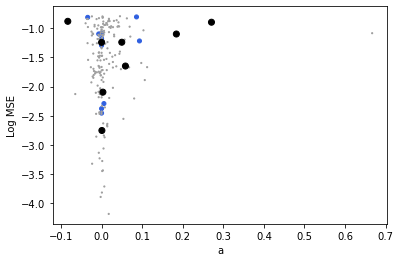

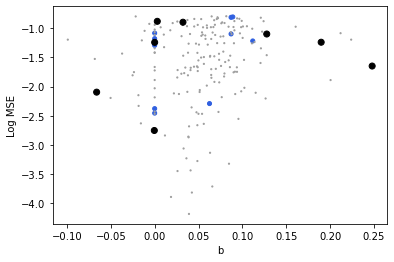

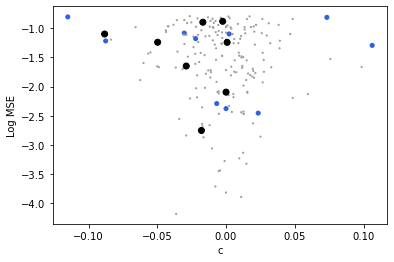

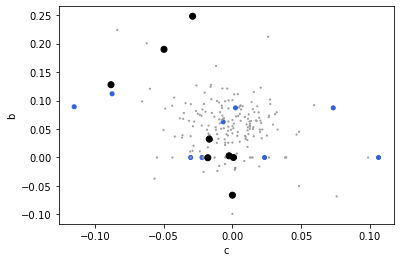

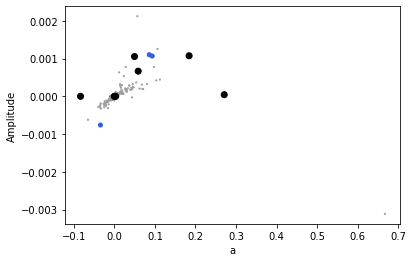

#A0A0A0    181
#3060E0     10
#000000      8
Name: color, dtype: int64
#A0A0A0    0.120667
#3060E0    0.006667
#000000    0.080000
Name: color, dtype: float64


In [38]:
a_s = np.array([sf[0] for sf in abcs if len(sf)>=5])
b_s = np.array([sf[1] for sf in abcs if len(sf)>=5])
c_s = np.array([sf[2] for sf in abcs if len(sf)>=5])
A_s = np.array([sf[3] for sf in abcs if len(sf)>=5])
MSEs = np.array([sf[4] for sf in abcs if len(sf)>=5])

MSEThreshold = 0.16
colors = ["#3060E0","#A0A0A0","#000000"]

nonkhamsa = 0
for sf in abcs:
    try:
        if (sf[4] < MSEThreshold):
            if(sf[6].coefficients()[1,3] != 0.0 or sf[6].coefficients()[0,1] != 0.0 or sf[6].coefficients()[0,3] != 0.0 or sf[6].coefficients()[0,4] != 0.0 or sf[6].coefficients()[0,5] != 0.0):
                nonkhamsa += 1
    except:
        nonkhamsa += 1

print(nonkhamsa)
        
        
a_s = a_s[MSEs < MSEThreshold]
b_s = b_s[MSEs < MSEThreshold]
c_s = c_s[MSEs < MSEThreshold]
cs = [colors[int(l)] for l, MSE in zip(labels, MSEs) if MSE < MSEThreshold]
theseStars = [s for s, MSE in zip(someStars, MSEs) if MSE < MSEThreshold]
ls = ((np.array([l for l, MSE in zip(labels, MSEs) if MSE < MSEThreshold]) - 0.8)**2)/(0.2**2)
A_s = A_s[MSEs < MSEThreshold]
MSEs = MSEs[MSEs < MSEThreshold]

print(len(abcs))
print(len(a_s))

daf=pd.DataFrame({"a":a_s, "b":b_s, "c":c_s, "A":A_s, "MSE":MSEs, "color":cs})
daf.to_csv("daf")

plt.scatter(a_s, np.log10(MSEs), c = cs, s=0.4+ls)
plt.xlabel("a")
plt.ylabel("Log MSE")
plt.show()

plt.scatter(b_s, np.log10(MSEs), c = cs, s=0.4+ls)
plt.xlabel("b")
plt.ylabel("Log MSE")
plt.show()

plt.scatter(c_s, np.log10(MSEs), c = cs, s=0.4+ls)
plt.xlabel("c")
plt.ylabel("Log MSE")
plt.show()

plt.scatter(A_s, np.log10(MSEs), c = cs, s=0.4+ls)
plt.xlabel("Amplitude")
plt.ylabel("Log MSE")
plt.show()

plt.scatter(a_s, b_s, c = cs, s=0.4+ls)
plt.xlabel("a")
plt.ylabel("b")
plt.show()

plt.scatter(a_s, c_s, c = cs, s=0.4+ls)
plt.xlabel("a")
plt.ylabel("c")
#plt.xlim([np.min(a_s), np.max(a_s)])
#plt.ylim([np.min(c_s), np.max(c_s)])
#plt.plot([-10.0, 10.0], [-10.0, 10.0], c='#FFF44F', linewidth=0.5)
plt.show()

plt.scatter(c_s, b_s, c = cs, s=0.4+ls)
plt.xlabel("c")
plt.ylabel("b")
plt.show()

plt.scatter(a_s, A_s, c = cs, s=0.4+ls)
plt.xlabel("a")
plt.ylabel("Amplitude")
plt.show()

plt.scatter(b_s, A_s, c = cs, s=0.4+ls)
plt.xlabel("b")
plt.ylabel("Amplitude")
plt.show()

plt.scatter(c_s, A_s, c = cs, s=0.4+ls)
plt.xlabel("c")
plt.ylabel("Amplitude")
plt.show()

print(daf["color"].value_counts())

print(daf["color"].value_counts()/np.array([1500,1500,100]))

In [ ]:
for filename in theseStars:
    bestr = 0.0
    bestnudge = [0,0]
    MSE = 1000.0
    for r in [0.01, 0.02, 0.05, 0.1]: #np.arange(0.01, 0.2, 0.01):
        modelt, MSEt, tt, Xt, st = sindyfy_lasso(filename, True, r, 2, [0,0], silent=True)
        if(MSEt < MSE):
            bestr = r
            MSE = MSEt
    #for dx, dy in zip(0.05*np.random.normal(size=10),0.05*np.random.normal(size=10)):
    #    nudge = [dx, dy]
    #    modelt, MSEt, tt, Xt, st = sindyfy_lasso(filename, True, bestr, 2, nudge, silent=True)
    #    if(MSEt < MSE):
    #        bestnudge = nudge
    #        MSE = MSEt
    modelt, MSEt, tt, Xt, st = sindyfy_lasso(filename, True, bestr, 2, bestnudge, silent=False)
    print(bestr, bestnudge)

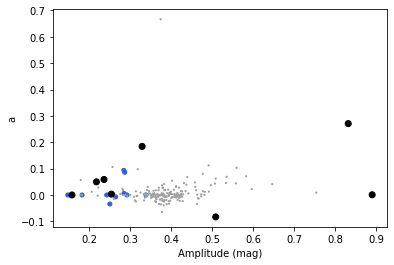

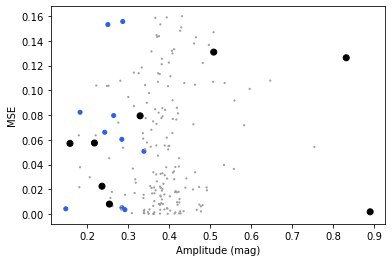

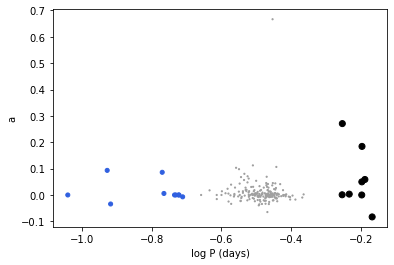

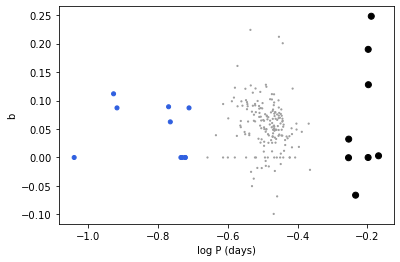

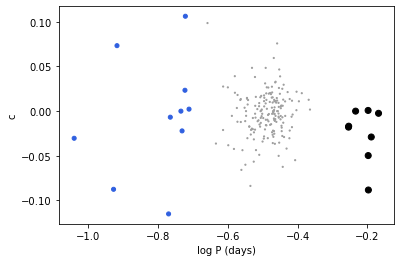

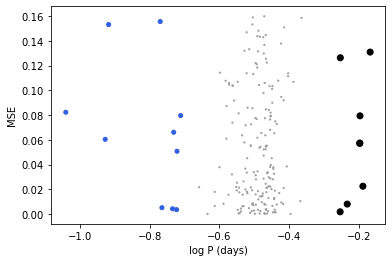

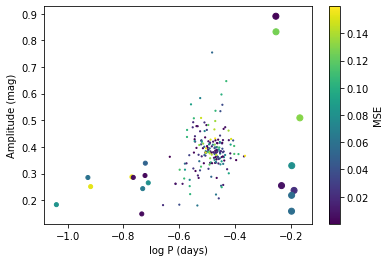

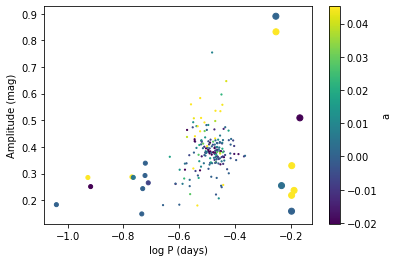

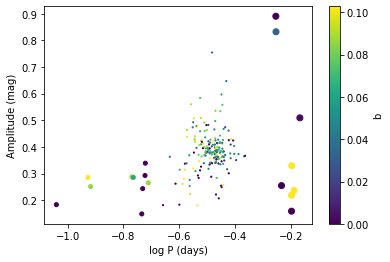

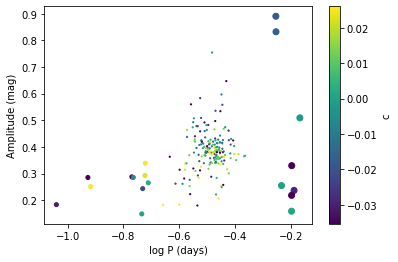

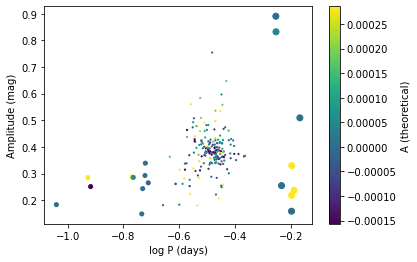

In [42]:
deltascutis = pd.read_csv("DeltaScuti9_Mario.csv")
rrcs = pd.read_csv("RRc2_Mario.csv")
rrabs = pd.read_csv("RRab1_Mario.csv")
P_deltascutis = deltascutis["Period"].to_numpy()
A_deltascutis = deltascutis["Amp"].to_numpy()
Id_deltascutis = deltascutis["Numerical_ID"].to_numpy()
P_rrcs = rrcs["Period"].to_numpy()
A_rrcs = rrcs["Amp"].to_numpy()
Id_rrcs = rrcs["Numerical_ID"].to_numpy()
P_rrabs = rrabs["Period"].to_numpy()
A_rrabs = rrabs["Amp"].to_numpy()
Id_rrabs = rrabs["Numerical_ID"].to_numpy()

theseStar_ids = np.array([int(os.path.split(s)[1][:-4]) for s in theseStars])

fitted_stars = pd.DataFrame({"ID":theseStar_ids, "a":a_s, "b":b_s, "c":c_s, "A_theoretical":A_s, "MSE":MSEs, "color":cs, "l":ls})
bayley_stars = pd.DataFrame({"ID":[*Id_deltascutis, *Id_rrcs, *Id_rrabs], "P":np.log10([*P_deltascutis, *P_rrcs, *P_rrabs]), "A_observational":[*A_deltascutis, *A_rrcs, *A_rrabs]})

plt.scatter(bayley_stars["P"], bayley_stars["A_observational"], s=0.5, c="#A0A0A0")
plt.ylabel("Amplitude (mag)")
plt.xlabel("log P (days)")
plt.show()
bailey_and_fitted = pd.merge(fitted_stars, bayley_stars, how='inner', left_on='ID', right_on='ID')

plt.scatter(bailey_and_fitted["A_observational"], bailey_and_fitted["a"], c=bailey_and_fitted["color"], s=0.4+ls)
plt.ylabel("a")
plt.xlabel("Amplitude (mag)")
plt.show()

plt.scatter(bailey_and_fitted["A_observational"], bailey_and_fitted["b"], c=bailey_and_fitted["color"], s=0.4+ls)
plt.ylabel("b")
plt.xlabel("Amplitude (mag)")
plt.show()

plt.scatter(bailey_and_fitted["A_observational"], bailey_and_fitted["c"], c=bailey_and_fitted["color"], s=0.4+ls)
plt.ylabel("c")
plt.xlabel("Amplitude (mag)")
plt.show()

plt.scatter(bailey_and_fitted["A_observational"], bailey_and_fitted["MSE"], c=bailey_and_fitted["color"], s=0.4+ls)
plt.ylabel("MSE")
plt.xlabel("Amplitude (mag)")
plt.show()

plt.scatter(bailey_and_fitted["P"], bailey_and_fitted["a"], c=bailey_and_fitted["color"], s=0.4+ls)
plt.ylabel("a")
plt.xlabel("log P (days)")
plt.show()

plt.scatter(bailey_and_fitted["P"], bailey_and_fitted["b"], c=bailey_and_fitted["color"], s=0.4+ls)
plt.ylabel("b")
plt.xlabel("log P (days)")
plt.show()

plt.scatter(bailey_and_fitted["P"], bailey_and_fitted["c"], c=bailey_and_fitted["color"], s=0.4+ls)
plt.ylabel("c")
plt.xlabel("log P (days)")
plt.show()

plt.scatter(bailey_and_fitted["P"], bailey_and_fitted["MSE"], c=bailey_and_fitted["color"], s=0.4+ls)
plt.ylabel("MSE")
plt.xlabel("log P (days)")
plt.show()

plt.scatter(bailey_and_fitted["P"], bailey_and_fitted["A_observational"], s=0.4+ls, c=(bailey_and_fitted["MSE"]))
plt.ylabel("Amplitude (mag)")
plt.xlabel("log P (days)")
clb = plt.colorbar()
clb.ax.set_ylabel("MSE")
plt.show()

def cap_to_quantiles(u):
    return(u.clip(np.quantile(u,0.1), np.quantile(u,0.9)))

plt.scatter(bailey_and_fitted["P"], bailey_and_fitted["A_observational"], s=0.4+ls, c=cap_to_quantiles(bailey_and_fitted["a"]))
plt.ylabel("Amplitude (mag)")
plt.xlabel("log P (days)")
clb = plt.colorbar()
clb.ax.set_ylabel("a")
plt.show()

plt.scatter(bailey_and_fitted["P"], bailey_and_fitted["A_observational"], s=0.4+ls, c=cap_to_quantiles(bailey_and_fitted["b"]))
plt.ylabel("Amplitude (mag)")
plt.xlabel("log P (days)")
clb = plt.colorbar()
clb.ax.set_ylabel("b")
plt.show()

plt.scatter(bailey_and_fitted["P"], bailey_and_fitted["A_observational"], s=0.4+ls, c=cap_to_quantiles(bailey_and_fitted["c"]))
plt.ylabel("Amplitude (mag)")
plt.xlabel("log P (days)")
clb = plt.colorbar()
clb.ax.set_ylabel("c")
plt.show()

plt.scatter(bailey_and_fitted["P"], bailey_and_fitted["A_observational"], s=0.4+ls, c=cap_to_quantiles(bailey_and_fitted["A_theoretical"]))
plt.ylabel("Amplitude (mag)")
plt.xlabel("log P (days)")
clb = plt.colorbar()
clb.ax.set_ylabel("A (theoretical)")
plt.show()